# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


<div style="font-size: 24px; line-height: 1.5; color: blue;">
Цель проекта
</div>

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Определить признаки и причины по которым пользователи чаще используют сервис на основе доступных данных с целью:
    <ul>
<li>Определить перспективных клиентов и как можно быстрее поспособствовать их переходу на платформу засчет персонализированных условий</li>
<li>Оптимально проводить рекламные компании для уменьшения числа возвратов заказов</li>
<li>Оптимизировать маркетинговые издержки и повысить удержание клиентов</li>
</ul>
</div>

In [1]:
import pandas as pd
from sqlalchemy import create_engine 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import requests
import io

from config import db_config

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [4]:
engine = create_engine(connection_string) 

In [5]:
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
        (p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk::DATE
    )) AS days_since_prev,
    p.event_id,
    p.service_name,
    e.event_type_main,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p
INNER JOIN afisha.events AS e USING (event_id)
JOIN afisha.city AS c USING (city_id)
JOIN afisha.regions AS r USING (region_id)
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
'''

In [6]:
df = pd.read_sql_query(query, con=engine) 

In [7]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
<li>В распоряжении 290611 строк и 14 столбцов</li>
<li>Пустые значения есть в столбце days_since_prev, т.к. пользователь мог совершить только один заказ</li>
<li>У столбца tickets_count можно уменьшить разрядность</li>
<li>Привести к нижнему регистру и проверить наличие дубликатов в столбцах currency_code, service_name, event_type_main, region_name, city_name </li>
<li>Проверить диапазоны значений в столбцах order_dt, order_ts, revenue, days_since_prev</li>
<li>Проверить валидность значений в столбцах tickets_count</li>
</ul>
</div>

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [9]:
url = 'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
response = requests.get(url, verify=False)
tenge_df = pd.read_csv(io.StringIO(response.text))

In [10]:
tenge_df

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


In [11]:
tenge_df['curs_per_unit'] = tenge_df['curs'] / tenge_df['nominal']
tenge_df

,data,nominal,curs,cdx,curs_per_unit
0,2024-01-10,100,19.9391,kzt,0.199391
1,2024-01-11,100,19.7255,kzt,0.197255
2,2024-01-12,100,19.5839,kzt,0.195839
3,2024-01-13,100,19.4501,kzt,0.194501
4,2024-01-14,100,19.4501,kzt,0.194501
...,...,...,...,...,...
352,2024-12-27,100,19.2705,kzt,0.192705
353,2024-12-28,100,19.5105,kzt,0.195105
354,2024-12-29,100,19.4860,kzt,0.194860
355,2024-12-30,100,19.4860,kzt,0.194860


In [12]:
curs_tenge = tenge_df['curs_per_unit'].mean()
curs_tenge

np.float64(0.19755817927170866)

In [13]:
print(df[df['currency_code'] == 'rub']['revenue'].mean())
print(df[df['currency_code'] == 'kzt']['revenue'].mean() * curs_tenge)
df['currency_code'].value_counts()

548.0139292643464
986.8439538992917


currency_code
rub    285542
kzt      5069
Name: count, dtype: int64

In [14]:
df['revenue_rub'] = np.where(
    df['currency_code'] == 'rub',
    df['revenue'],
    df['revenue'] * curs_tenge  # если тенге (предполагаем, что другие валюты - тенге)
)

In [15]:
df['revenue_rub'].mean()

np.float64(555.6682485945663)

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Проверили среднее значение до и после конвертации, чтобы убедиться в отсутствии очевидных ошибок. Учитывая что количество оплат в тенге меньше 2%, то среднее значение в рублях не должно сильно измениться - так и получилось - было 548, стало 556
</div>

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [16]:
df['tickets_count'].value_counts()

tickets_count
3     92247
2     83807
4     54812
1     41798
5     13476
6      4283
7        62
9        38
8        21
10       19
11       13
13        7
17        6
19        5
12        4
14        4
15        2
27        2
30        2
47        1
57        1
37        1
Name: count, dtype: int64

In [17]:
print(df['tickets_count'].min())
print(df['tickets_count'].max())
df['tickets_count'].dtype

1
57


dtype('int64')

In [18]:
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')

In [19]:
df['tickets_count'].dtype

dtype('int8')

In [20]:
df['service_name'] = df['service_name'].str.lower()

In [21]:
df['service_name'].value_counts()

service_name
билеты без проблем        63519
лови билет!               41124
билеты в руки             40343
мой билет                 34839
облачко                   26642
лучшие билеты             17774
весь в билетах            16849
прачечная                 10273
край билетов               6207
тебе билет!                5228
яблоко                     5039
дом культуры               4502
за билетом!                2865
городской дом культуры     2733
show_ticket                2200
мир касс                   2167
быстробилет                2003
выступления.ру             1616
восьмёрка                  1118
crazy ticket!               790
росбилет                    539
шоу начинается!             499
быстрый кассир              381
радио ticket                376
телебилет                   321
карандашру                  133
реестр                      125
билет по телефону            85
вперёд!                      80
дырокол                      74
кино билет                 

In [22]:
df['event_type_main'] = df['event_type_main'].str.lower()

In [23]:
df['event_type_main'].value_counts()

event_type_main
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: count, dtype: int64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Заметим что значительная часть данных по типу мероприятия - это "другое". Возможно информация отсутствовала
</div>

In [24]:
df['region_name'] = df['region_name'].str.lower()

In [25]:
with pd.option_context('display.max_rows', None):
    print(df['region_name'].value_counts())

region_name
каменевский регион           91058
североярская область         44049
широковская область          16457
медовская область            13901
озернинский край             10476
светополянский округ          7607
малиновоярский округ          6618
речиновская область           6293
солнечноземская область       6288
яблоневская область           6181
серебринская область          5610
горицветская область          5166
травяная область              5045
лугоградская область          4701
тепляковская область          4389
солнечнореченская область     3996
зоринский регион              3214
глиногорская область          3214
шанырский регион              2882
чистогорская область          2686
лесодальний край              2577
верхоречная область           2387
заречная область              2160
травиницкий округ             1779
ветренский регион             1768
боровлянский край             1721
каменноозёрный край           1658
речицкий регион               1590
каменноя

In [26]:
df['city_name'] = df['city_name'].str.lower()

In [27]:
with pd.option_context('display.max_rows', None): print(df['city_name'].value_counts())

city_name
глиногорск        89446
озёрск            43910
радужсвет         13711
радужнополье       8741
верховино          6579
дальнесветск       6293
глинополье         6196
светополье         5993
глиноград          5934
лесоярич           5831
озёрчане           4790
островецк          4722
кристалевск        4690
родниковецк        4568
горнодолинск       3926
ягодиновка         3557
родниковск         3219
луговинск          3214
озёрово            2463
родниковец         2436
серебрянка         2387
теплоозеро         2264
леснойск           2235
широковка          2185
луговаярово        2142
дальнесветин       1834
кокжар             1762
ордакент           1645
глинянск           1590
серебровино        1566
каменский          1563
сарыжар            1475
златопольск        1251
лесоярово          1192
сосновечин         1174
никольянов         1172
ордасай            1109
речинцево           980
горнополец          903
солчелуг            901
тихоярск            821
жаркен

In [28]:
print(df['order_dt'].min())
print(df['order_dt'].max())
df['order_dt']

2024-06-01 00:00:00
2024-10-31 00:00:00


0        2024-08-20
1        2024-07-23
2        2024-10-06
3        2024-07-13
4        2024-10-04
            ...    
290606   2024-10-27
290607   2024-10-27
290608   2024-10-30
290609   2024-09-24
290610   2024-09-25
Name: order_dt, Length: 290611, dtype: datetime64[ns]

In [29]:
print(df['order_ts'].min())
print(df['order_ts'].max())
df['order_ts']

2024-06-01 00:00:42
2024-10-31 23:59:54


0        2024-08-20 16:08:03
1        2024-07-23 18:36:24
2        2024-10-06 13:56:02
3        2024-07-13 19:40:48
4        2024-10-04 22:33:15
                 ...        
290606   2024-10-27 17:53:53
290607   2024-10-27 17:54:52
290608   2024-10-30 13:37:43
290609   2024-09-24 10:07:42
290610   2024-09-25 15:12:40
Name: order_ts, Length: 290611, dtype: datetime64[ns]

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Поле order_dt дублирует информацию в order_ts, поэтому можно было бы не учитывать order_dt, а использовать только order_ts. Оба столбца содержат информацию за 2024 год, но все же думаю лучше оставить информацию по году, т.к. конкретный год нигде не зафиксирован в тз и данные в бд могут обновляться.
</div>

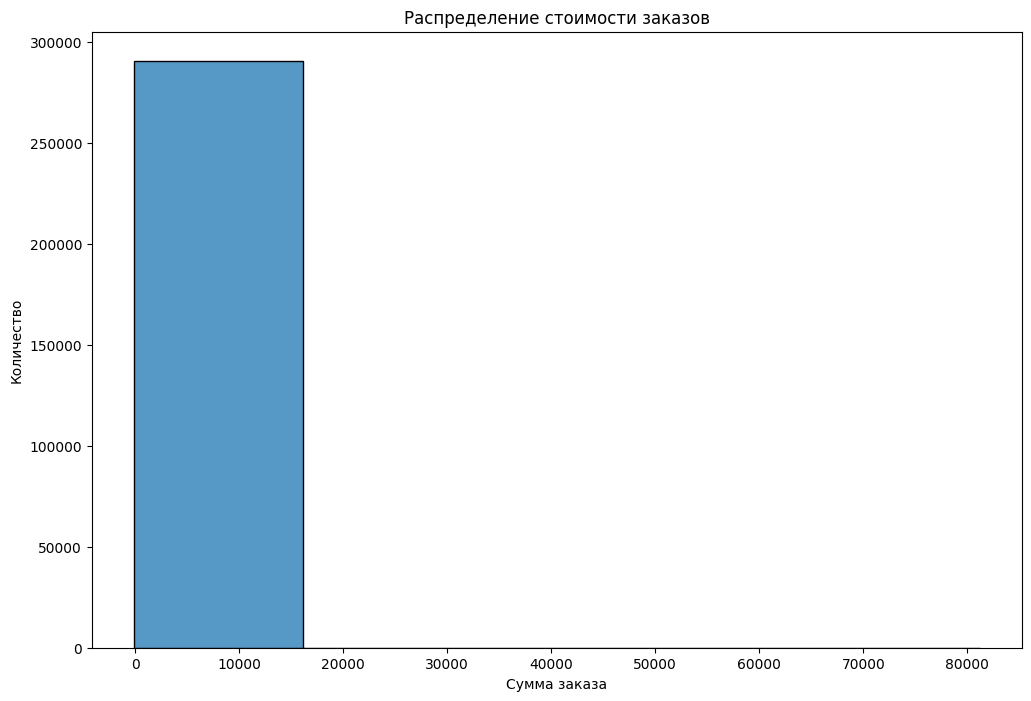

In [30]:
plt.figure(figsize=(12, 8))

sns.histplot(data=df, x='revenue_rub', bins=5)

plt.title('Распределение стоимости заказов')
plt.xlabel('Сумма заказа')
plt.ylabel('Количество')
plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Гистограмма малоинформативна из-за выбросов
</div>

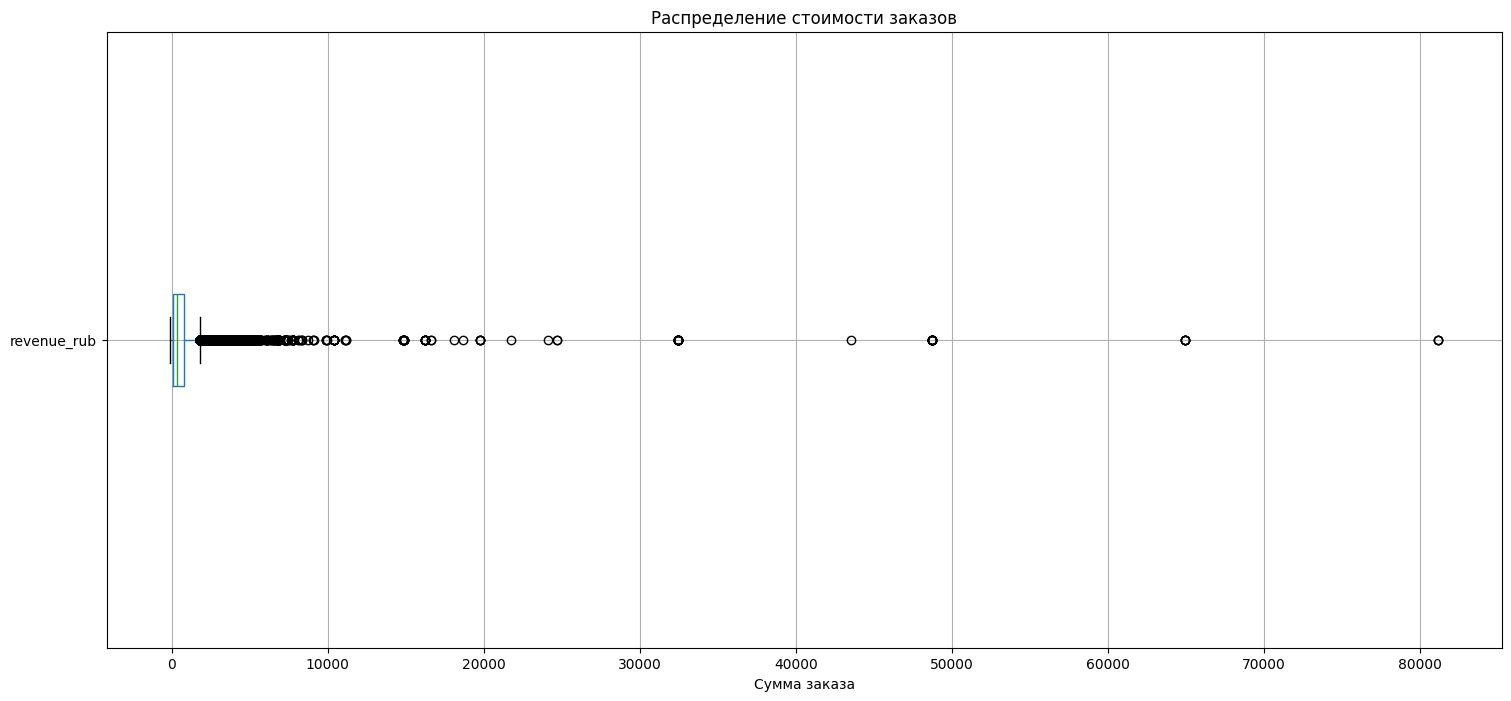

In [31]:
plt.figure(figsize=(18, 8))

df.boxplot(column='revenue_rub', vert=False)

plt.title('Распределение стоимости заказов')
plt.xlabel('Сумма заказа')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Диаграмма размаха явно отобразила выбросы. Отфильтруем по 99 персентилю
</div>

In [32]:
percentile_99 = df['revenue_rub'].quantile(0.99)
df_filtered = df[df['revenue_rub'] <= percentile_99]

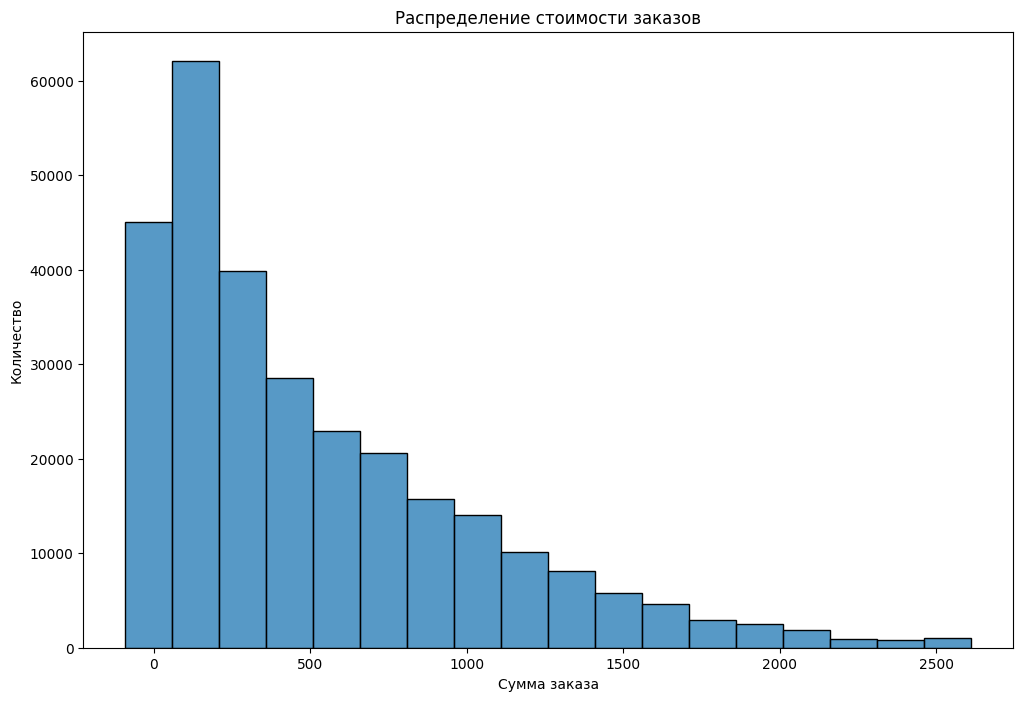

In [33]:
plt.figure(figsize=(12, 8))

sns.histplot(data=df_filtered, x='revenue_rub', bins=18)

plt.title('Распределение стоимости заказов')
plt.xlabel('Сумма заказа')
plt.ylabel('Количество')
plt.show()

In [34]:
df['revenue_rub'].describe()

count    290611.000000
mean        555.668249
std         875.469763
min         -90.760000
25%         113.970000
50%         351.870000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

In [35]:
df_filtered['revenue_rub'].describe()

count    287741.000000
mean        517.815301
std         511.384479
min         -90.760000
25%         111.860000
50%         344.260000
75%         788.640000
max        2610.322394
Name: revenue_rub, dtype: float64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
После фильтрации по 99 персентилю гистограмма наглядно отобразила распределение стоимости заказов. В основном стоимость заказа не превышает 500 руб. Так же видим наличие отрицательных значения стоимости.
</div>

In [36]:
df_negative_revenue = df[df['revenue_rub'] < 0]

In [37]:
df_negative_revenue['revenue_rub'].describe()

count    381.000000
mean      -2.492362
std        5.065072
min      -90.760000
25%       -3.450000
50%       -1.580000
75%       -0.650000
max       -0.010000
Name: revenue_rub, dtype: float64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Всего заказов отрицательной стоимостью 381 - на так много по сравнению с общим числом
</div>

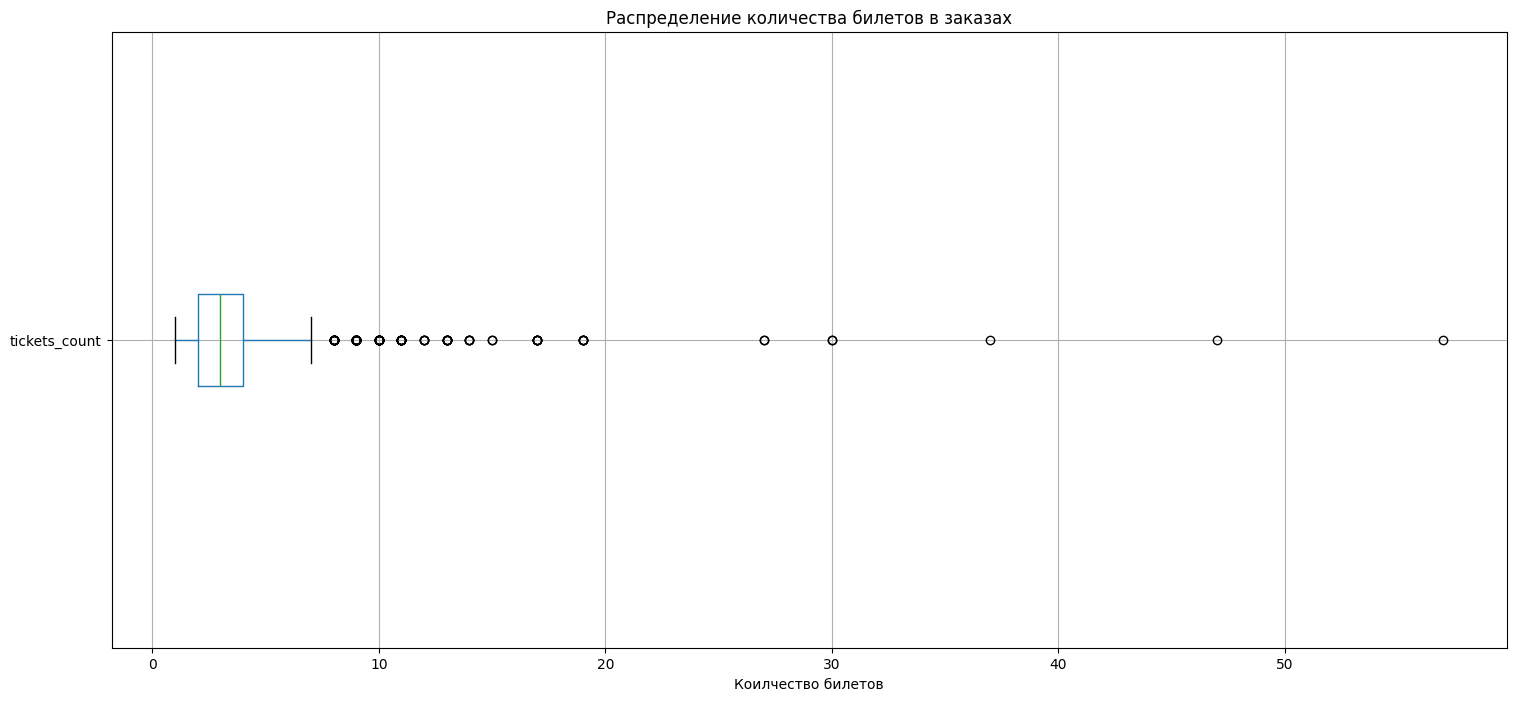

In [38]:
plt.figure(figsize=(18, 8))

df.boxplot(column='tickets_count', vert=False)

plt.title('Распределение количества билетов в заказах')
plt.xlabel('Коилчество билетов')

plt.show()

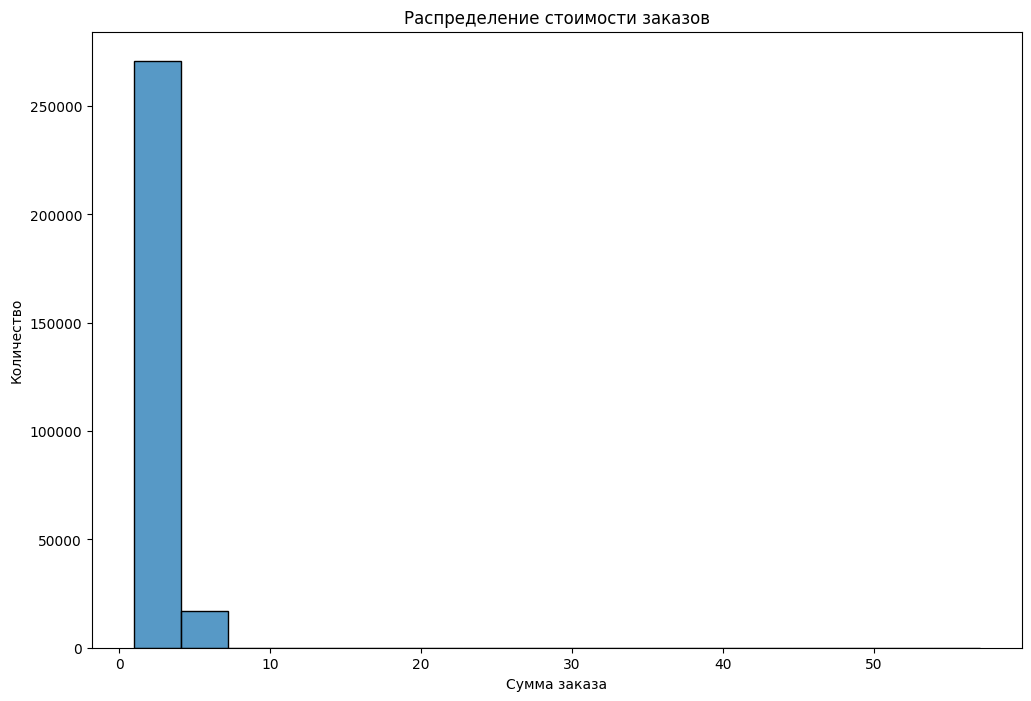

In [39]:
plt.figure(figsize=(12, 8))

sns.histplot(data=df_filtered, x='tickets_count', bins=18)

plt.title('Распределение стоимости заказов')
plt.xlabel('Сумма заказа')
plt.ylabel('Количество')
plt.show()

In [40]:
df_filtered['tickets_count'].value_counts()

tickets_count
3     91724
2     83649
4     53633
1     41788
5     12844
6      3923
7        58
9        38
10       19
8        18
11       13
13        7
17        6
19        5
14        4
12        3
15        2
27        2
30        2
47        1
57        1
37        1
Name: count, dtype: int64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Видим выбросы, попробуем отфильтровать по количеству билетов не больше 10
</div>

In [41]:
df_filtered_tickets = df_filtered[df_filtered['tickets_count'] <= 10]

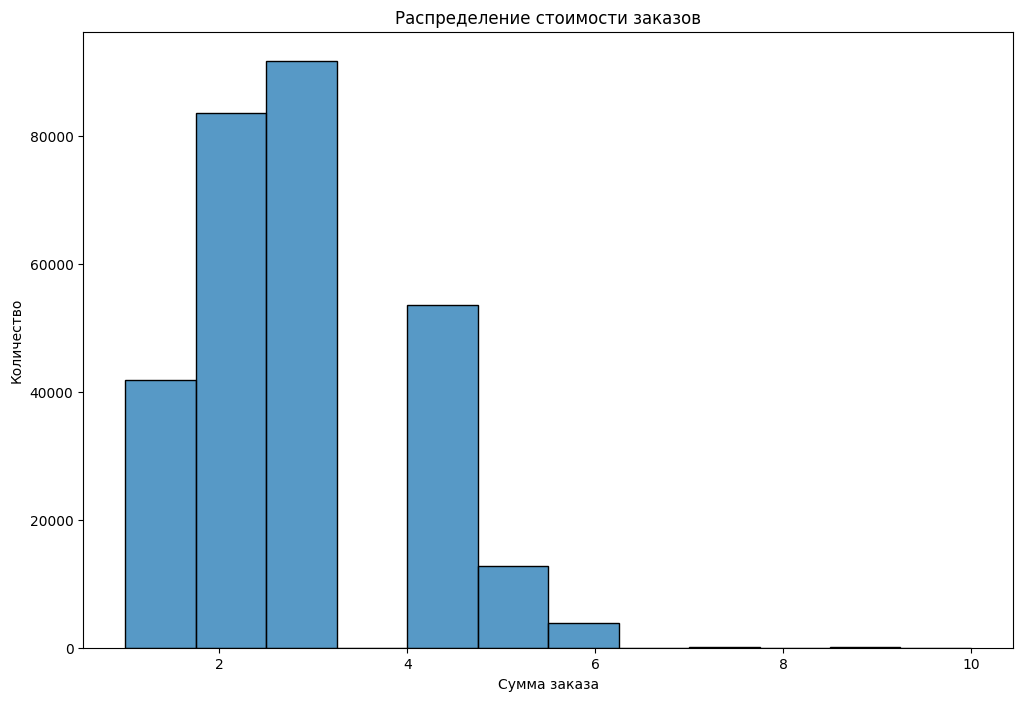

In [42]:
plt.figure(figsize=(12, 8))

sns.histplot(data=df_filtered_tickets, x='tickets_count', bins=12)

plt.title('Распределение стоимости заказов')
plt.xlabel('Сумма заказа')
plt.ylabel('Количество')
plt.show()

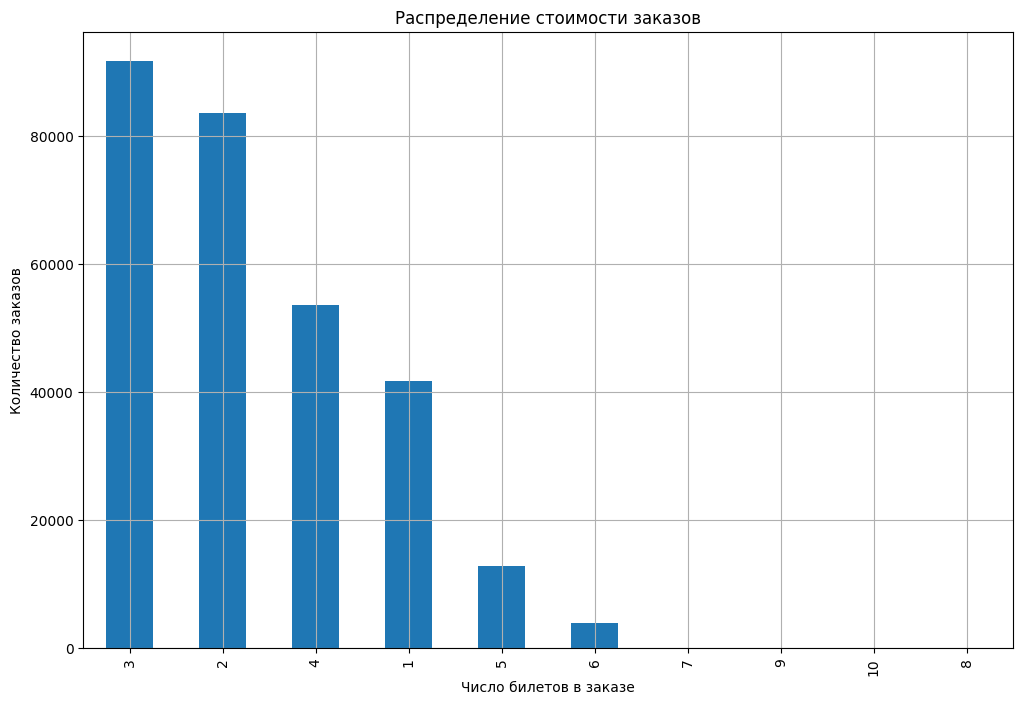

In [43]:
plt.figure(figsize=(12, 8))

df_filtered_tickets['tickets_count'].value_counts().plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Распределение стоимости заказов'
)

plt.grid()
plt.xlabel('Число билетов в заказе')
plt.ylabel('Количество заказов')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По столбчатой диаграмме видим, что наибоее часто заказы содержат по 3 или 2 билета
</div>

In [44]:
print(df.shape)
print(df_filtered_tickets.shape)
print(df.shape[0] - df_filtered_tickets.shape[0])

(290611, 15)
(287694, 15)
2917


<div style="font-size: 24px; line-height: 1.5; color: blue;">
Вывод по предобработке данных
</div>

<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
<li>Добавлен столбец revenue_rub, т.е. имеющийся стобец revenue содержал разные значения по валюте</li>
<li>Отфильтрованы заказы по выбросам по стоимости и по количеству билетов - убрано 2917 записей (около 1%)</li>
<li>Нормализованы столбцы city_name, region_name, event_type_main, service_name</li>
<li>Получена информация по распределению revenue_rub и tickets_count</li>
</ul>
</div>

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [45]:
user_profile = df_filtered_tickets.groupby('user_id').agg(
    first_order_date=('order_dt', 'min'),
    last_order_date=('order_dt', 'max'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_partner=('service_name', 'first'), # Билетный партнер первого заказа
    first_genre=('event_type_main', 'first'),
    total_orders=('order_id', 'nunique'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'), # Среднее количество билетов в заказе
    avg_days_between_orders=('days_since_prev', 'mean')     # Среднее время между заказами (исключая NaN)
).reset_index()

In [46]:
# Совершил ли пользователь 2 и более заказа
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
# Совершил ли пользователь 5 и более заказов
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

In [47]:
print(user_profile.shape)
print(user_profile.head())

(21849, 13)
           user_id first_order_date last_order_date first_device  \
0  0002849b70a3ce2       2024-08-20      2024-08-20       mobile   
1  0005ca5e93f2cf4       2024-07-23      2024-10-06       mobile   
2  000898990054619       2024-07-13      2024-10-23       mobile   
3  00096d1f542ab2b       2024-08-15      2024-08-15      desktop   
4  000a55a418c128c       2024-09-29      2024-10-15       mobile   

           first_region  first_partner first_genre  total_orders  \
0    каменевский регион   край билетов       театр             1   
1    каменевский регион      мой билет    выставки             2   
2  североярская область    лови билет!      другое             3   
3    каменевский регион   край билетов       театр             1   
4      поленовский край  лучшие билеты       театр             2   

   avg_revenue_rub  avg_tickets  avg_days_between_orders  is_two  is_five  
0      1521.940000     4.000000                      NaN       0        0  
1       774.010000

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [48]:
total_users = len(user_profile)
print(f"Общее число пользователей в выборке: {total_users}")

total_revenue = (user_profile['avg_revenue_rub'] * user_profile['total_orders']).sum()
total_orders = user_profile['total_orders'].sum()
avg_revenue_per_order = total_revenue / total_orders
print(f"Средняя выручка с одного заказа (общая): {avg_revenue_per_order:.2f} руб.")

users_two_plus = user_profile['is_two'].sum()
ratio_two_plus = users_two_plus / total_users
print(f"Доля пользователей с 2+ заказами: {ratio_two_plus:.2%} ({users_two_plus} из {total_users})")

users_five_plus = user_profile['is_five'].sum()
ratio_five_plus = users_five_plus / total_users
print(f"Доля пользователей с 5+ заказами: {ratio_five_plus:.2%} ({users_five_plus} из {total_users})")

Общее число пользователей в выборке: 21849
Средняя выручка с одного заказа (общая): 517.74 руб.
Доля пользователей с 2+ заказами: 61.71% (13482 из 21849)
Доля пользователей с 5+ заказами: 29.01% (6338 из 21849)


In [49]:
user_profile['total_orders'].describe()

count    21849.000000
mean        13.167376
std        121.625932
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10177.000000
Name: total_orders, dtype: float64

In [50]:
with pd.option_context('display.max_rows', None):
    print(user_profile[user_profile['total_orders'] > 100]['total_orders'].value_counts().sort_index())

total_orders
101      3
102      5
103      1
104      6
105      4
106      5
107      1
108      1
109      4
110      5
111      2
112      2
113      9
114      2
115      1
116      1
117      3
118      5
119      3
120      2
121      3
122      3
123      4
124      2
125      2
127      3
128      3
129      2
130      2
131      3
132      3
133      1
134      4
135      6
136      1
137      1
139      3
140      2
141      3
142      1
143      1
144      2
145      3
146      1
147      1
148      1
149      4
151      2
152      4
154      2
156      2
157      1
158      3
159      1
160      2
161      1
162      2
165      1
166      1
167      2
170      1
172      1
175      1
176      1
178      2
180      2
182      3
183      2
184      1
185      4
190      1
192      1
193      2
194      1
196      1
199      2
200      2
202      1
203      1
204      1
208      1
210      1
211      1
213      2
214      1
216      1
218      1
220      1
224      1
225     

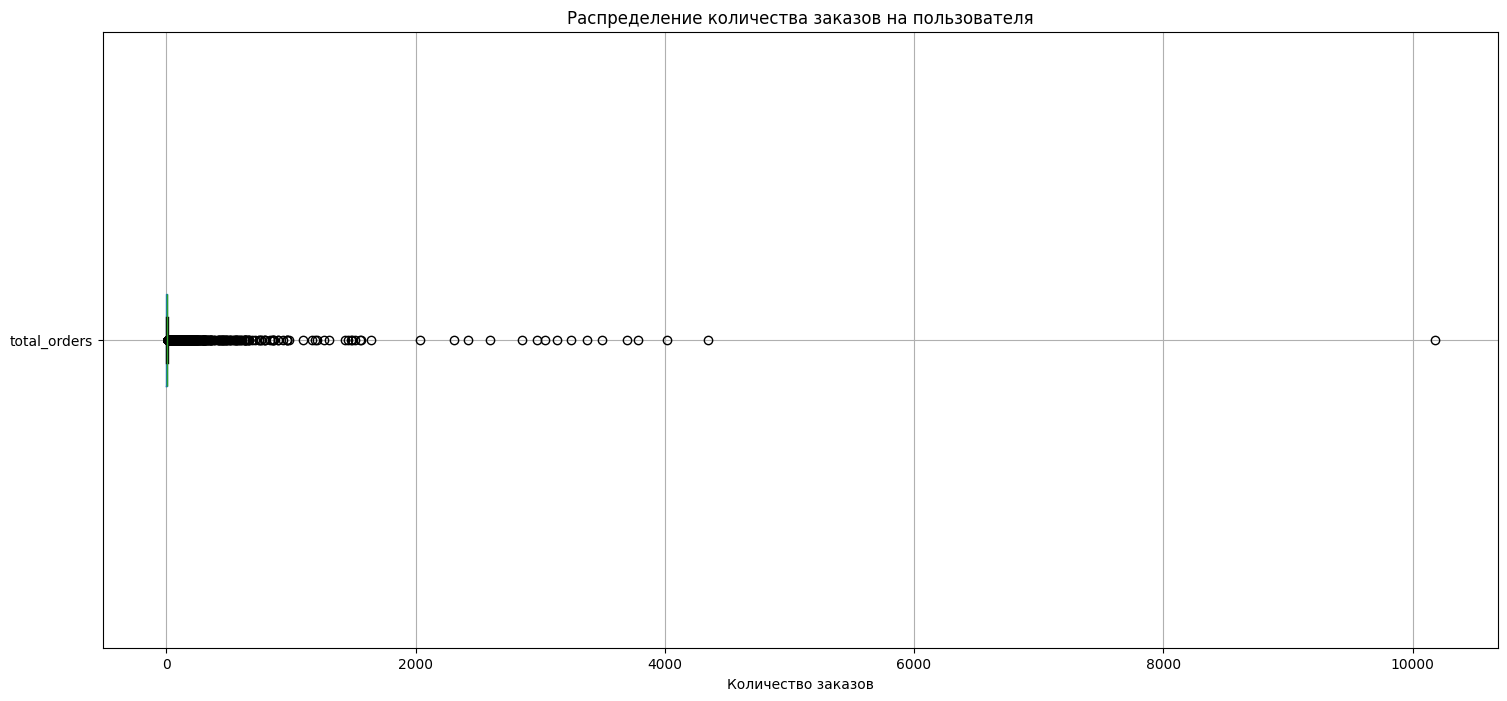

In [51]:
plt.figure(figsize=(18, 8))

user_profile.boxplot(column='total_orders', vert=False)

plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По полученной информации о количестве заказов на пользователя видим большое стандартное отклонение (121) по сравнению со средним значением (13) 
и большое количество выбросов на диаграмме размаха. Думаю надо пробовать фильтровать данные, для начала по 99-му персентилю
</div>

In [52]:
percentile_99 = user_profile['total_orders'].quantile(0.99)
user_profile_total_orders_99 = user_profile[user_profile['total_orders'] <= percentile_99]

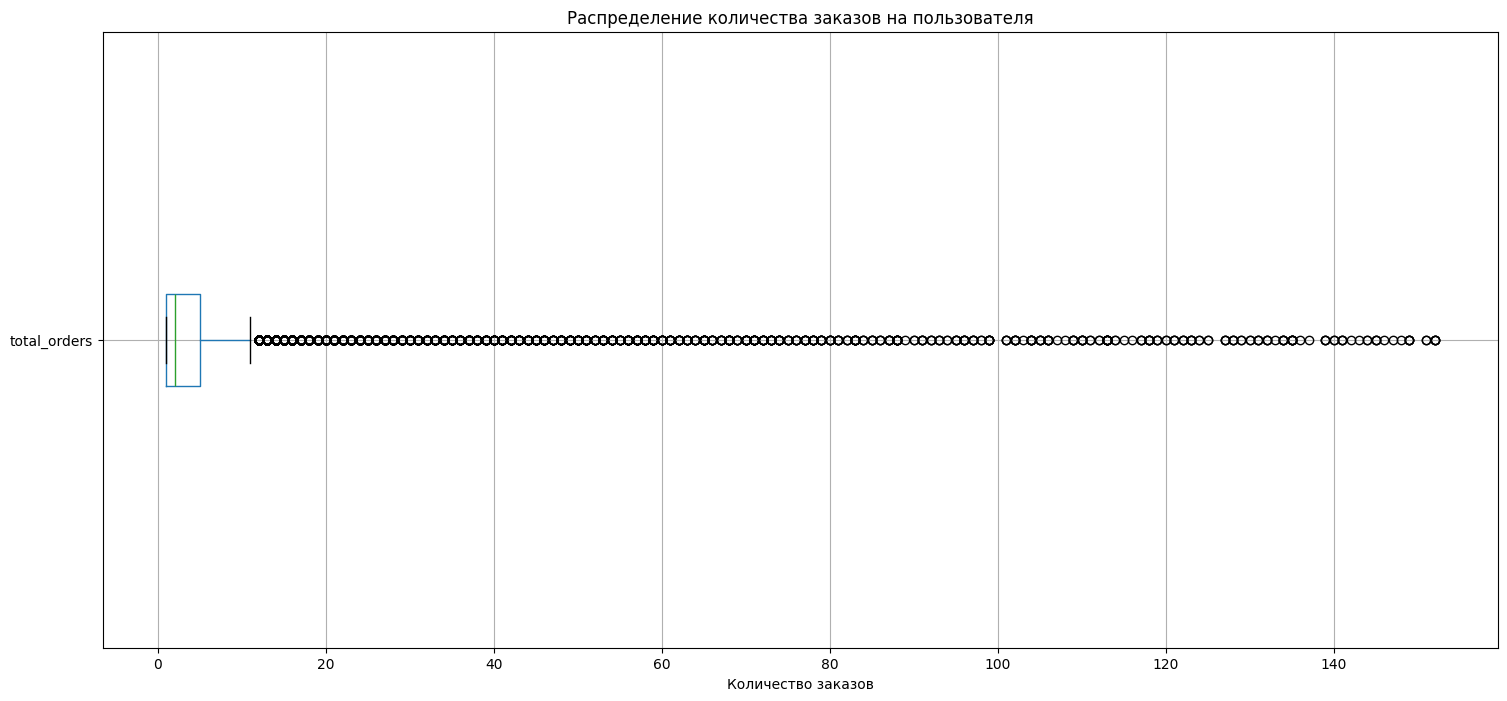

In [53]:
plt.figure(figsize=(18, 8))

user_profile_total_orders_99.boxplot(column='total_orders', vert=False)

plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Все еще достаточно большое количество выбросов и ящик не так выражен на диаграмме
</div>

In [54]:
percentile_95 = user_profile['total_orders'].quantile(0.95)
user_profile_total_orders_95 = user_profile[user_profile['total_orders'] <= percentile_95]

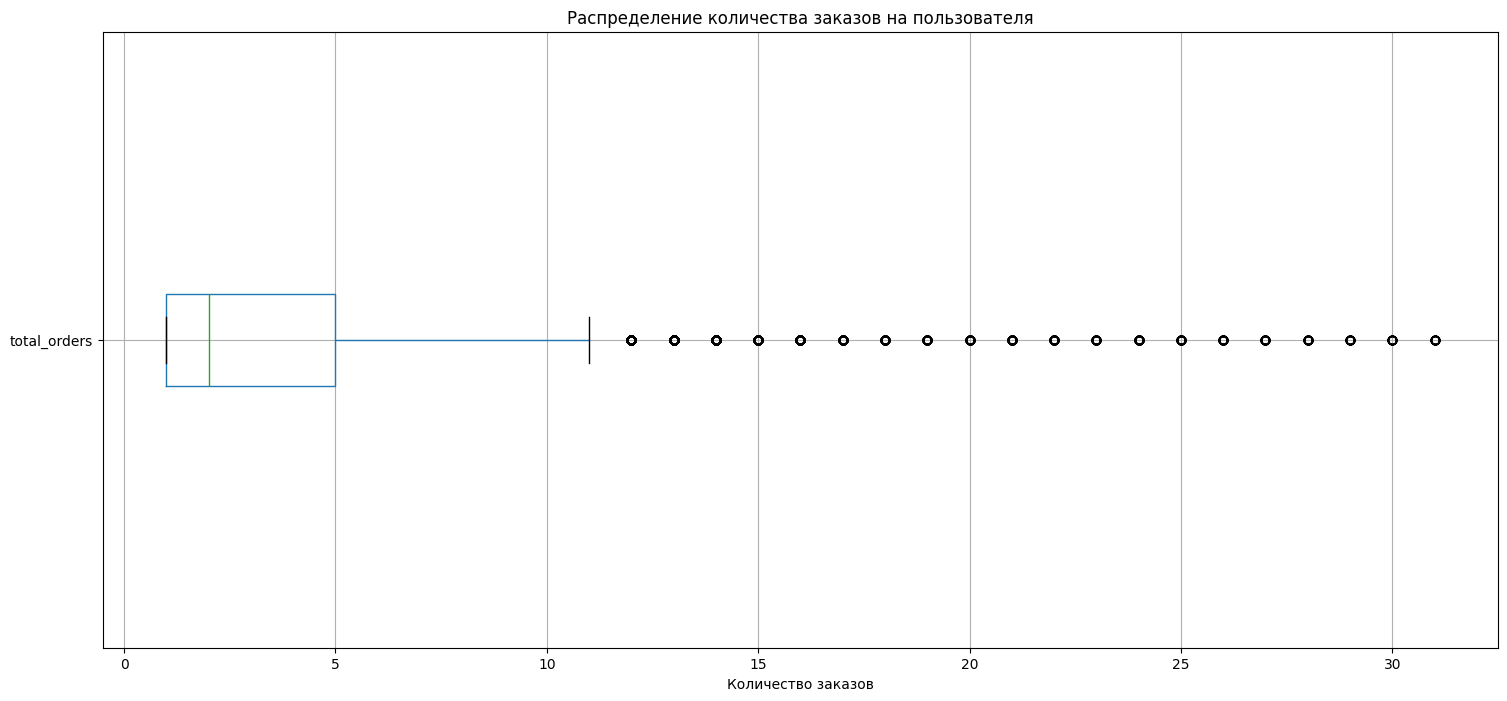

In [55]:
plt.figure(figsize=(18, 8))

user_profile_total_orders_95.boxplot(column='total_orders', vert=False)

plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')

plt.show()

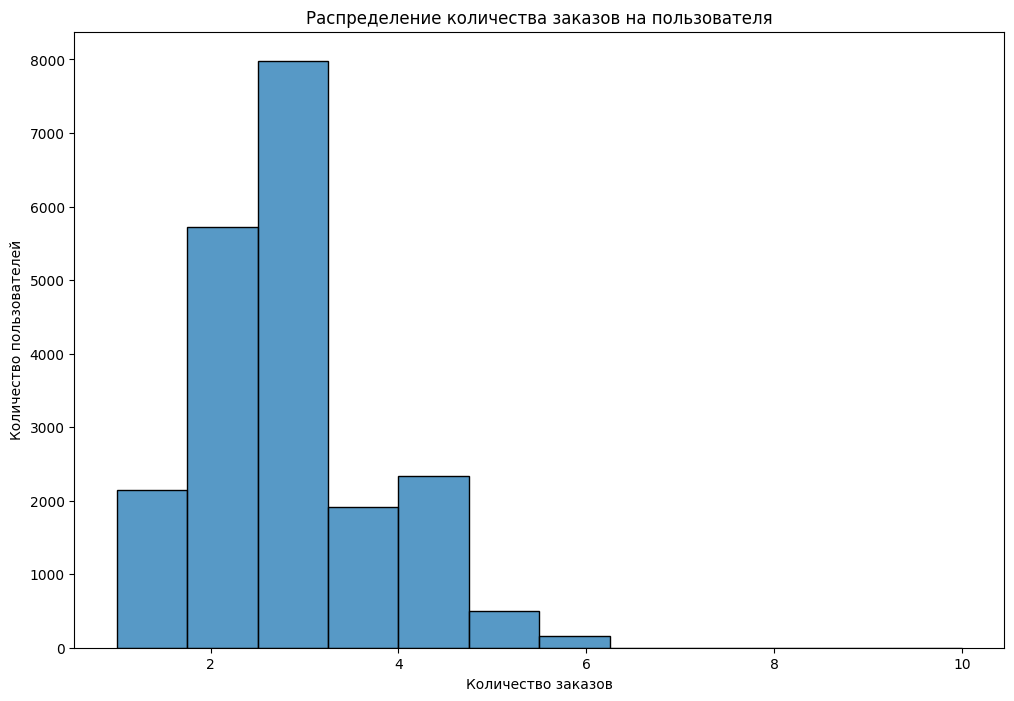

In [56]:
plt.figure(figsize=(12, 8))

sns.histplot(data=user_profile_total_orders_95, x='avg_tickets', bins=12)

plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

In [57]:
user_profile['avg_tickets'].describe()

count    21849.000000
mean         2.741055
std          0.907861
min          1.000000
25%          2.000000
50%          2.750000
75%          3.071429
max         10.000000
Name: avg_tickets, dtype: float64

In [58]:
user_profile_total_orders_95['avg_tickets'].describe()

count    20757.000000
mean         2.741567
std          0.929287
min          1.000000
25%          2.000000
50%          2.750000
75%          3.142857
max         10.000000
Name: avg_tickets, dtype: float64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Характеристики среднего количества билетов практически не изменились после фильтрации
</div>

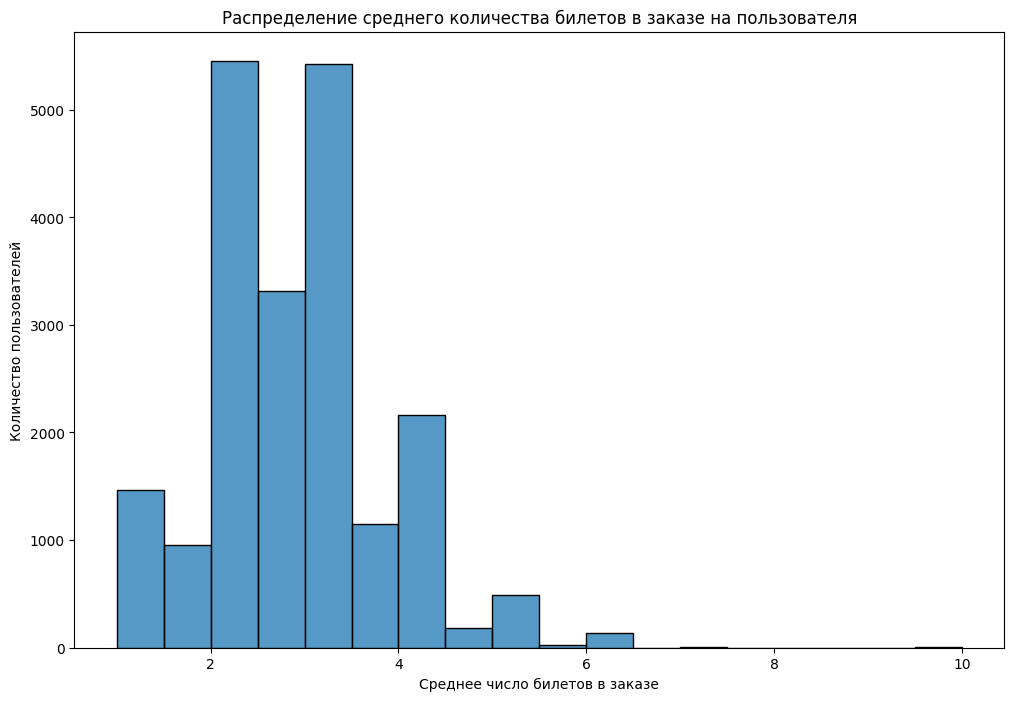

In [59]:
plt.figure(figsize=(12, 8))

sns.histplot(data=user_profile_total_orders_95, x='avg_tickets', bins=18)

plt.title('Распределение среднего количества билетов в заказе на пользователя')
plt.xlabel('Среднее число билетов в заказе')
plt.ylabel('Количество пользователей')
plt.show()

In [60]:
repeat_buyers = user_profile[user_profile['total_orders'] > 1]
repeat_buyers['avg_days_between_orders'].describe()

count    13482.000000
mean        15.808878
std         22.214232
min          0.000000
25%          1.000000
50%          8.000000
75%         20.333333
max        148.000000
Name: avg_days_between_orders, dtype: float64

In [61]:
repeat_buyers = user_profile_total_orders_95[user_profile_total_orders_95['total_orders'] > 1]
repeat_buyers['avg_days_between_orders'].describe()

count    12390.000000
mean        17.011802
std         22.780656
min          0.000000
25%          1.000000
50%          9.461538
75%         22.000000
max        148.000000
Name: avg_days_between_orders, dtype: float64

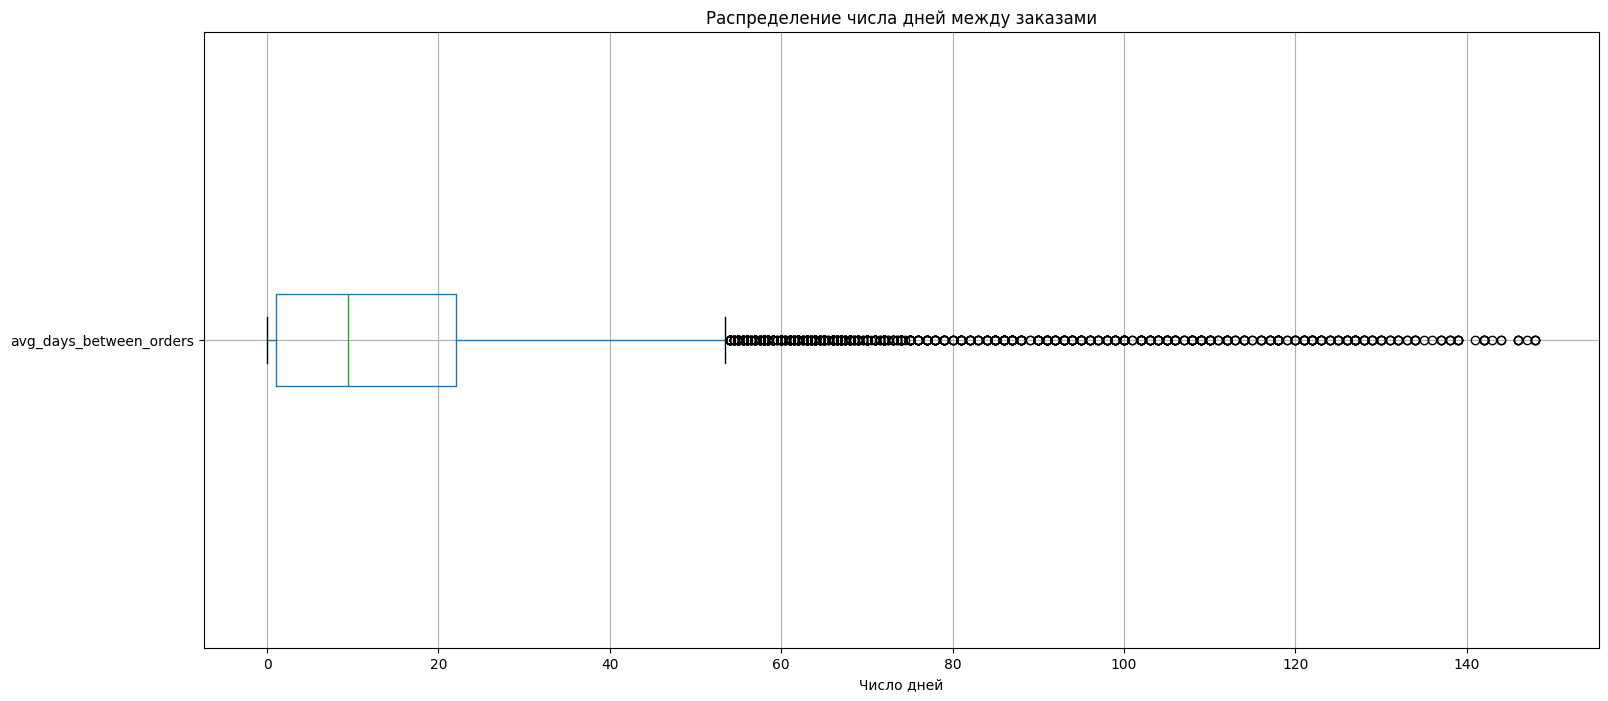

In [62]:
plt.figure(figsize=(18, 8))

user_profile_total_orders_95.boxplot(column='avg_days_between_orders', vert=False)

plt.title('Распределение числа дней между заказами')
plt.xlabel('Число дней')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Для показателей среднего количества дней между заказами стандартное отклонение больше среднего значения. Кажется тут для получения общих выводов по данным далее так же можно попробовать убрать по 95-му персентилю
</div>

In [63]:
print(user_profile_total_orders_95.shape)

(20757, 13)


In [64]:
percentile_95_days = user_profile_total_orders_95['avg_days_between_orders'].quantile(0.95)
user_profile_filtered = user_profile_total_orders_95[
    (user_profile_total_orders_95['avg_days_between_orders'] <= percentile_95_days) | 
    (user_profile_total_orders_95['avg_days_between_orders'].isna())
]

In [65]:
print(user_profile_filtered.shape)

(20146, 13)


In [66]:
user_profile_filtered['avg_days_between_orders'].describe()

count    11807.000000
mean        13.100553
std         14.380022
min          0.000000
25%          0.666667
50%          8.733333
75%         19.333333
max         64.000000
Name: avg_days_between_orders, dtype: float64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Заметим, что почти половина значений для среднего числа дней между заказми - пустые значение, т.к. это число пользователей сделали только один заказ и кажется именно на эту аудиторию придется делать акцент, чтобы понять причину
</div>

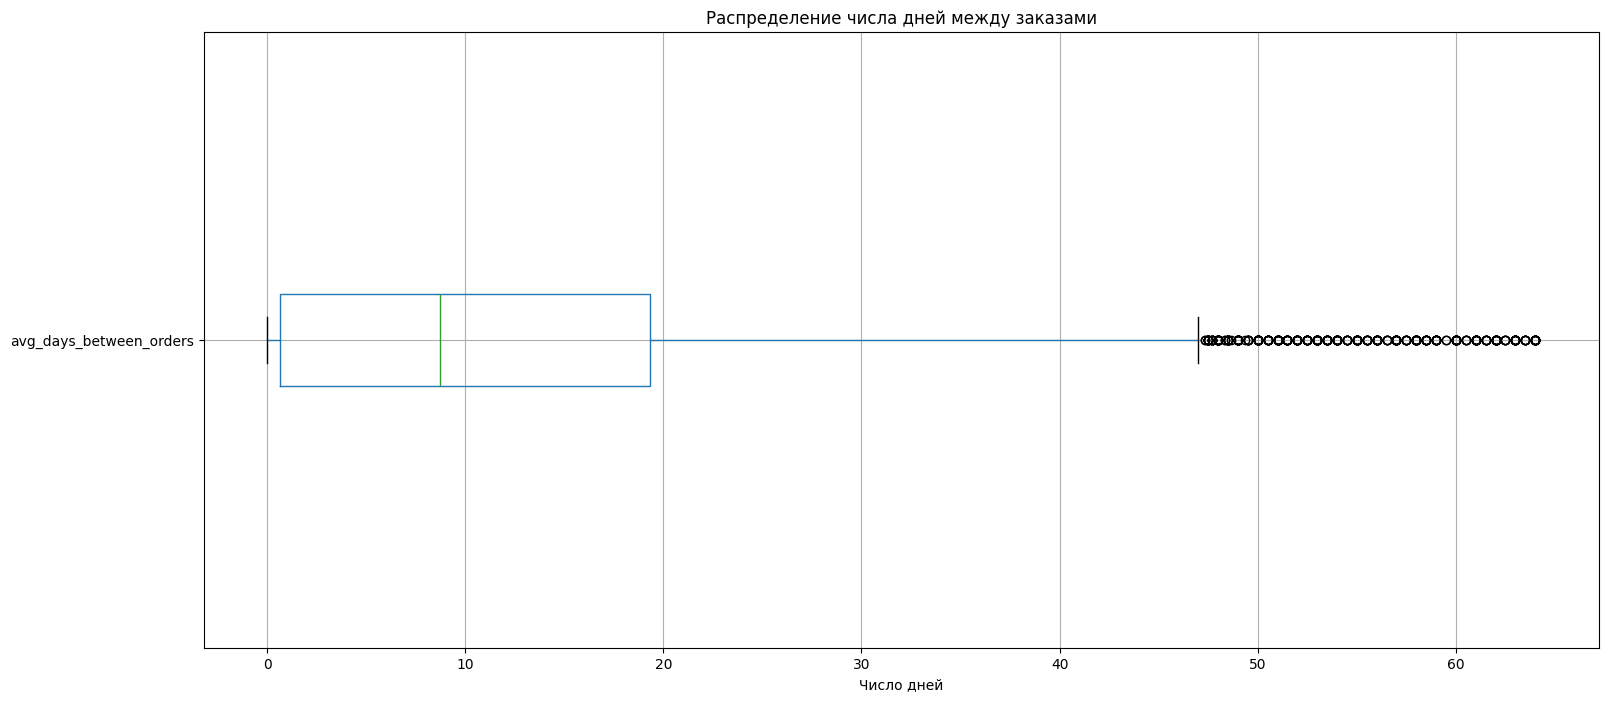

In [67]:
plt.figure(figsize=(18, 8))

user_profile_filtered.boxplot(column='avg_days_between_orders', vert=False)

plt.title('Распределение числа дней между заказами')
plt.xlabel('Число дней')

plt.show()

In [68]:
print(user_profile.shape)
print(user_profile_filtered.shape)

(21849, 13)
(20146, 13)


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Отфильтровали почти 8% данных чтобы приблизить значения стандартных отклонений и средних значений для показателей количества заказов пользователей, а так же средним количеством дней между заказами. Не исключаю возможность вернуться к этому моменту фильтрации при формировании конечных выводов далее.
</div>

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [69]:
#Группировка по типу первого мероприятия
event_type_groups = user_profile_filtered.groupby('first_genre').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile_filtered) * 100)
).round(2).sort_values('total_users', ascending=False)
event_type_groups

,total_users,percentage
first_genre,,
концерты,8903,44.19
другое,5027,24.95
театр,3945,19.58
стендап,1041,5.17
спорт,760,3.77
выставки,379,1.88
ёлки,91,0.45


<div style="font-size: 18px; line-height: 1.5; color: blue;">
При группировке по типу первого мероприятия выделяются категории "концерты", "другое" и "театр"
</div>

In [70]:
#Группировка по типу устройства с которого совершена первая покупка
device_groups = user_profile_filtered.groupby('first_device').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile_filtered) * 100)
).round(2).sort_values('total_users', ascending=False)
device_groups

,total_users,percentage
first_device,,
mobile,16700,82.89
desktop,3446,17.11


<div style="font-size: 18px; line-height: 1.5; color: blue;">
В основном первый заказ делают с мобильного устройства - почти 83% пользователей
</div>

In [71]:
#Группировка по региону проведения мероприятия из первого заказа
region_groups = user_profile_filtered.groupby('first_region').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile_filtered) * 100)
).round(2).sort_values('total_users', ascending=False)
region_groups

,total_users,percentage
first_region,,
каменевский регион,6534,32.43
североярская область,3483,17.29
широковская область,1151,5.71
озернинский край,641,3.18
малиновоярский округ,498,2.47
...,...,...
залесский край,2,0.01
верхозёрский край,1,0.00
светолесский край,1,0.00


<div style="font-size: 18px; line-height: 1.5; color: blue;">
А из регонов для первого мероприятия выделяются 'каменевский регион' - 32.43% и 'североярская область' - 17.29%
</div>

In [72]:
#Группировка по билетному оператору, продавшему билеты на первый заказ
partner_groups = user_profile_filtered.groupby('first_partner').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile_filtered) * 100)
).round(2).sort_values('total_users', ascending=False)
partner_groups

,total_users,percentage
first_partner,,
билеты без проблем,4807,23.86
мой билет,2784,13.82
лови билет!,2646,13.13
билеты в руки,2350,11.66
облачко,2045,10.15
весь в билетах,1192,5.92
лучшие билеты,1108,5.50
прачечная,526,2.61
край билетов,424,2.10


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Основным поставщиком билетов является 'билеты без проблем' - 23.86% что почти в 2 раза больше чем у оператора на втором месте
</div>

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [73]:
#Группировка по типу первого мероприятия с отображением процента пользователей с повторными заказами
event_type_groups_2_orders = user_profile_filtered.groupby('first_genre').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile_filtered) * 100),
    users_with_2plus_orders=('is_two', 'sum')
).round(2)
event_type_groups_2_orders['repeat_ratio'] = (event_type_groups_2_orders['users_with_2plus_orders'] / event_type_groups_2_orders['total_users'] * 100).round(2)
event_type_groups_2_orders = event_type_groups_2_orders.sort_values('repeat_ratio', ascending=False)

event_type_groups_2_orders

,total_users,percentage,users_with_2plus_orders,repeat_ratio
first_genre,,,,
выставки,379,1.88,230,60.69
театр,3945,19.58,2393,60.66
концерты,8903,44.19,5260,59.08
стендап,1041,5.17,607,58.31
другое,5027,24.95,2837,56.44
ёлки,91,0.45,49,53.85
спорт,760,3.77,409,53.82


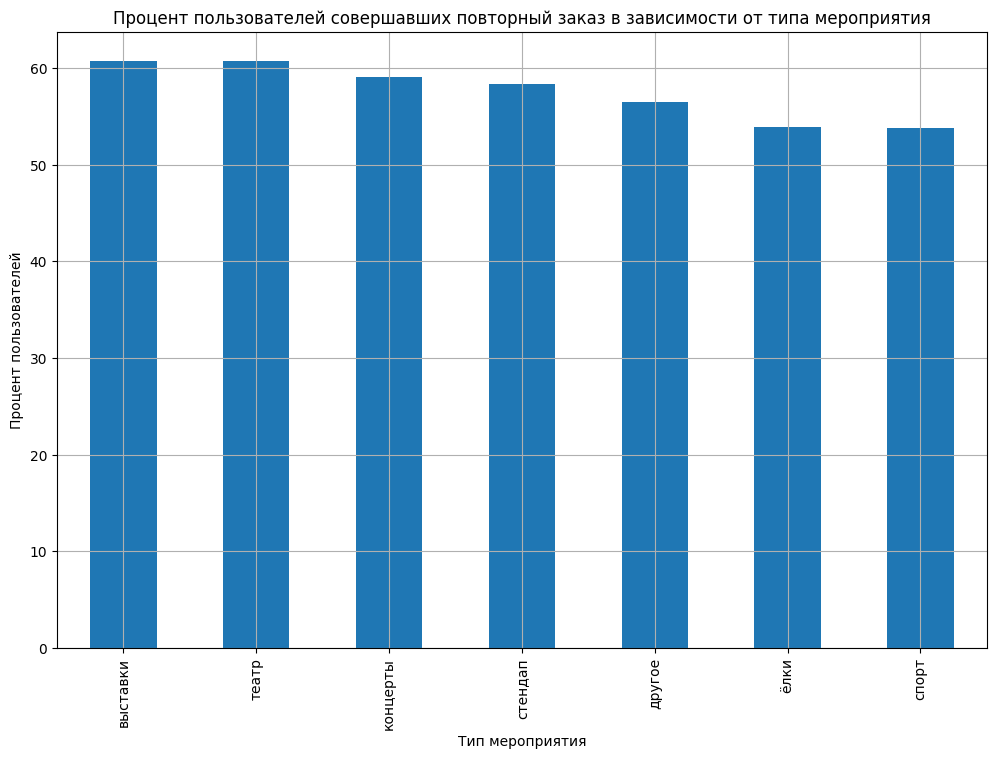

In [74]:
plt.figure(figsize=(12, 8))

event_type_groups_2_orders['repeat_ratio'].plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Процент пользователей совершавших повторный заказ в зависимости от типа мероприятия'
)

plt.grid()
plt.xlabel('Тип мероприятия')
plt.ylabel('Процент пользователей')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Кажется можно выделить сегмент 'театр' с небольшим отрывом и достаточно большим количетвом пользователей
</div>

In [75]:
#Группировка по типу устройства с которого совершена первая покупка с отображением процента пользователей с повторными заказами
device_groups_2_orders = user_profile_filtered.groupby('first_device').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile_filtered) * 100),
    users_with_2plus_orders=('is_two', 'sum')
).round(2)
device_groups_2_orders['repeat_ratio'] = (device_groups_2_orders['users_with_2plus_orders'] / device_groups_2_orders['total_users'] * 100).round(2)
device_groups_2_orders = device_groups_2_orders.sort_values('repeat_ratio', ascending=False)

device_groups_2_orders

,total_users,percentage,users_with_2plus_orders,repeat_ratio
first_device,,,,
desktop,3446,17.11,2104,61.06
mobile,16700,82.89,9681,57.97


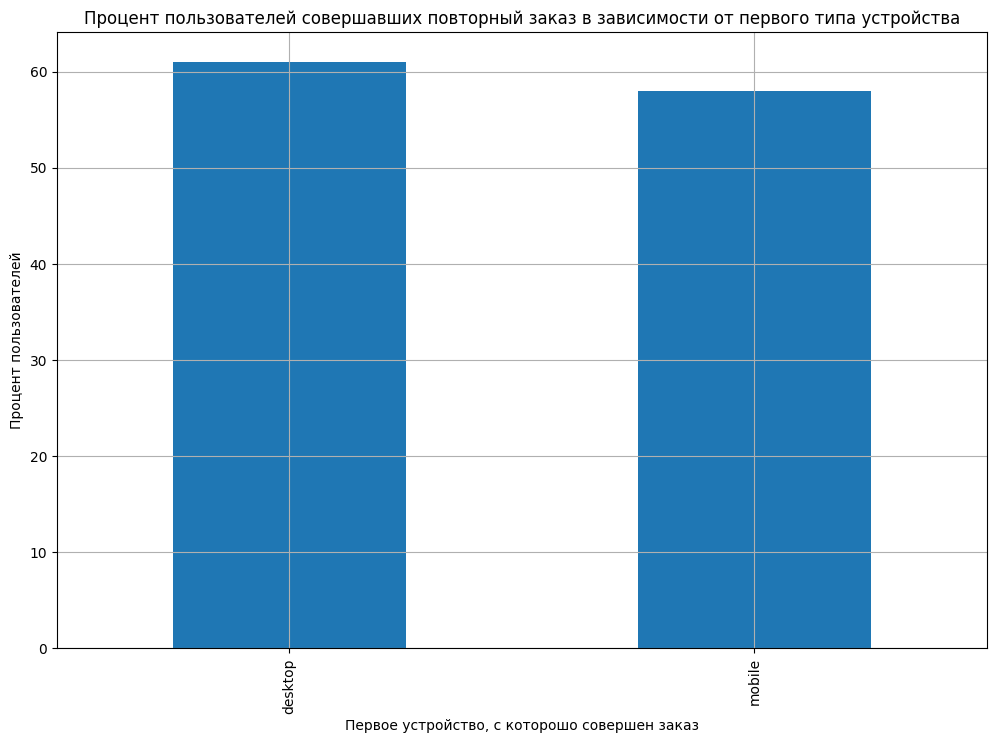

In [76]:
plt.figure(figsize=(12, 8))

device_groups_2_orders['repeat_ratio'].plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Процент пользователей совершавших повторный заказ в зависимости от первого типа устройства'
)

plt.grid()
plt.xlabel('Первое устройство, с которошо совершен заказ')
plt.ylabel('Процент пользователей')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
С компьютера чуть выше вероятность совершения повтоного заказа - 61% против 58% у мобильных устройств, но кажется в целом незначительно, учитывая еще отличающийся размер аудитории в сегментах
</div>

In [77]:
#Группировка по региону проведения мероприятия из первого заказа с отображением процента пользователей с повторными заказами
region_groups_2_orders = user_profile_filtered.groupby('first_region').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile_filtered) * 100),
    users_with_2plus_orders=('is_two', 'sum')
).round(2)
region_groups_2_orders = region_groups_2_orders[region_groups_2_orders['percentage'] > 2]
region_groups_2_orders['repeat_ratio'] = (region_groups_2_orders['users_with_2plus_orders'] / region_groups_2_orders['total_users'] * 100).round(2)
region_groups_2_orders = region_groups_2_orders.sort_values('repeat_ratio', ascending=False)

region_groups_2_orders

,total_users,percentage,users_with_2plus_orders,repeat_ratio
first_region,,,,
светополянский округ,427,2.12,270,63.23
шанырский регион,445,2.21,281,63.15
широковская область,1151,5.71,717,62.29
североярская область,3483,17.29,2119,60.84
речиновская область,406,2.02,247,60.84
каменевский регион,6534,32.43,3873,59.27
травяная область,450,2.23,262,58.22
малиновоярский округ,498,2.47,267,53.61
озернинский край,641,3.18,339,52.89


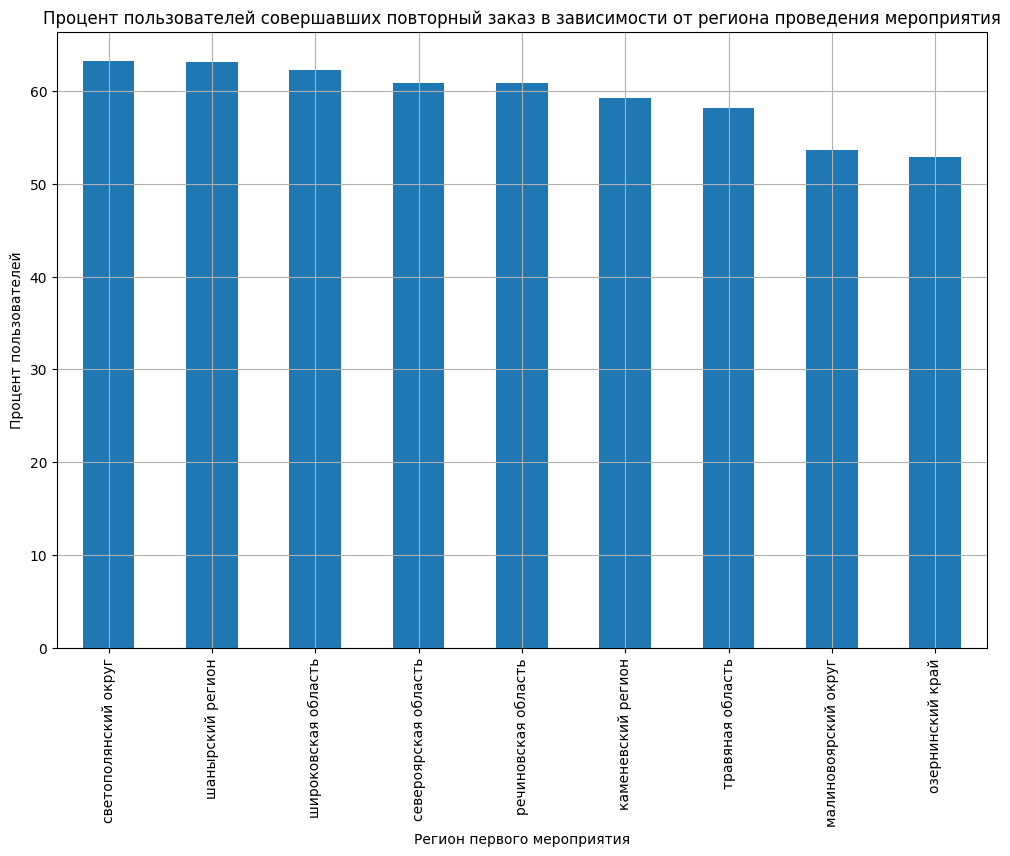

In [78]:
plt.figure(figsize=(12, 8))

region_groups_2_orders['repeat_ratio'].head(10).sort_values(ascending=False).plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Процент пользователей совершавших повторный заказ в зависимости от региона проведения мероприятия'
)

plt.grid()
plt.xlabel('Регион первого мероприятия')
plt.ylabel('Процент пользователей')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По типу региона есть лидеры где более 62% пользователей сделали повторный заказ - это 'шанырский регион' 'светополянский округ' и 'широковская область	'
</div>

In [79]:
#Группировка по билетному оператору, продавшему билеты на первый заказ с отображением процента пользователей с повторными заказами
partner_groups_2_orders = user_profile_filtered.groupby('first_partner').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile_filtered) * 100),
    users_with_2plus_orders=('is_two', 'sum')
).round(2)
partner_groups_2_orders = partner_groups_2_orders[partner_groups_2_orders['percentage'] > 1]
partner_groups_2_orders['repeat_ratio'] = (partner_groups_2_orders['users_with_2plus_orders'] / partner_groups_2_orders['total_users'] * 100).round(2)
partner_groups_2_orders = partner_groups_2_orders.sort_values('repeat_ratio', ascending=False)

partner_groups_2_orders

,total_users,percentage,users_with_2plus_orders,repeat_ratio
first_partner,,,,
край билетов,424,2.10,265,62.50
дом культуры,316,1.57,192,60.76
весь в билетах,1192,5.92,715,59.98
билеты в руки,2350,11.66,1397,59.45
облачко,2045,10.15,1203,58.83
лучшие билеты,1108,5.50,649,58.57
прачечная,526,2.61,308,58.56
тебе билет!,294,1.46,172,58.50
лови билет!,2646,13.13,1548,58.50


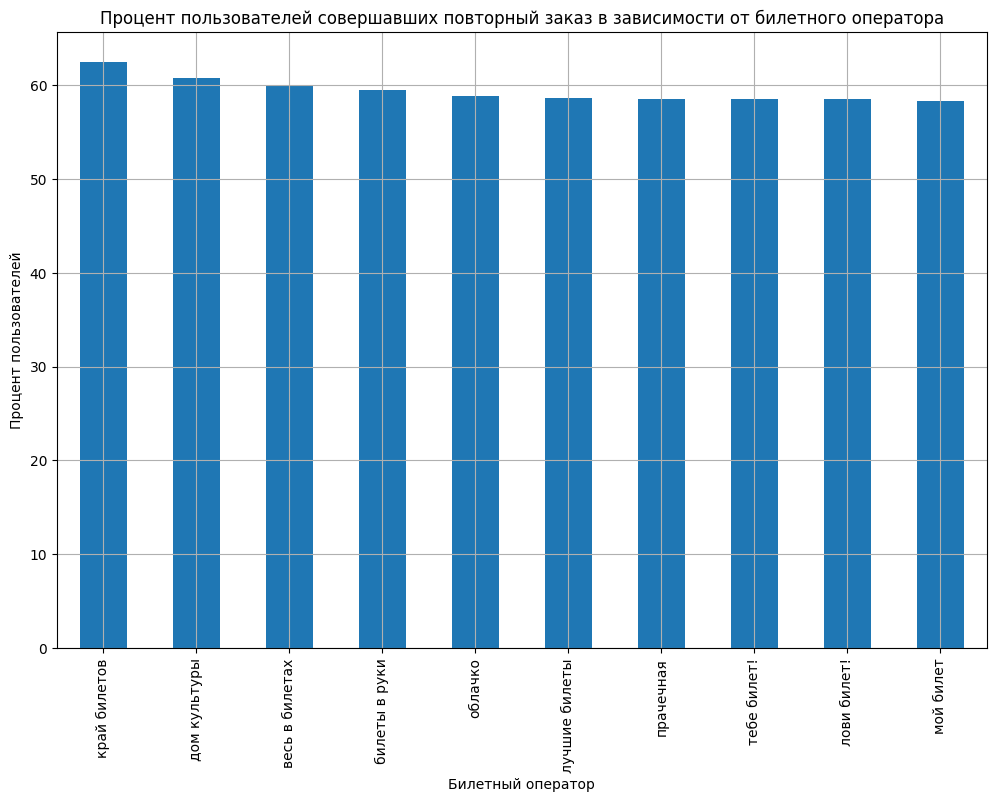

In [80]:
plt.figure(figsize=(12, 8))

partner_groups_2_orders['repeat_ratio'].head(10).sort_values(ascending=False).plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Процент пользователей совершавших повторный заказ в зависимости от билетного оператора'
)

plt.grid()
plt.xlabel('Билетный оператор')
plt.ylabel('Процент пользователей')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По билетным операторам лидеры где более 60% пользователей сделали повторный заказ это 'край билетов' и 'дом культуры'. Так же можно попробовать выявить проблемных операторов с самым низким процентом
</div>

In [81]:
#Группировка по билетному оператору, продавшему билеты на первый заказ с отображением процента пользователей с повторными заказами
partner_groups_2_orders_bad = user_profile_filtered.groupby('first_partner').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile_filtered) * 100),
    users_with_2plus_orders=('is_two', 'sum')
).round(2)
partner_groups_2_orders_bad = partner_groups_2_orders_bad[partner_groups_2_orders_bad['percentage'] > 0.1]
partner_groups_2_orders_bad['repeat_ratio'] = (partner_groups_2_orders_bad['users_with_2plus_orders'] / partner_groups_2_orders_bad['total_users'] * 100).round(2)
partner_groups_2_orders_bad = partner_groups_2_orders_bad.sort_values('repeat_ratio', ascending=True)

partner_groups_2_orders_bad

,total_users,percentage,users_with_2plus_orders,repeat_ratio
first_partner,,,,
радио ticket,34,0.17,13,38.24
телебилет,26,0.13,11,42.31
яблоко,293,1.45,146,49.83
билеты без проблем,4807,23.86,2755,57.31
городской дом культуры,207,1.03,119,57.49
за билетом!,196,0.97,113,57.65
быстробилет,157,0.78,91,57.96
мой билет,2784,13.82,1622,58.26
лови билет!,2646,13.13,1548,58.50


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Тут выделяется 'яблоко' с аудиторией 146 и 49.83%, что ниже средних значений, но в целом аудитория маленькая
</div>

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Гипотезу 1 отклоняем, т. к. пользователей купивших повторный билет после спорта - 53.82%, а после концента 59.08%
</div>

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По гипотезе 2 так же не получается сделать однозначный вывод, т.к. есть регионы с меньшей аудиторией, но бОльшим процентом покупки повторного билета
</div>

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [82]:
single_order_users = user_profile_filtered[user_profile_filtered['total_orders'] == 1]
repeat_users = user_profile_filtered[user_profile_filtered['total_orders'] >= 2]

In [83]:
print(f"Пользователей с 1 заказом: {len(single_order_users):,}")
print(f"Пользователей с 2+ заказами: {len(repeat_users):,}")

print(f"\nСредняя выручка с заказа:")
print(f"  - 1 заказ: {single_order_users['avg_revenue_rub'].mean():.2f} руб.")
print(f"  - 2+ заказов: {repeat_users['avg_revenue_rub'].mean():.2f} руб.")

print(f"\nМедианная выручка с заказа:")
print(f"  - 1 заказ: {single_order_users['avg_revenue_rub'].median():.2f} руб.")
print(f"  - 2+ заказов: {repeat_users['avg_revenue_rub'].median():.2f} руб.")

Пользователей с 1 заказом: 8,361
Пользователей с 2+ заказами: 11,785

Средняя выручка с заказа:
  - 1 заказ: 544.97 руб.
  - 2+ заказов: 546.37 руб.

Медианная выручка с заказа:
  - 1 заказ: 378.37 руб.
  - 2+ заказов: 494.41 руб.


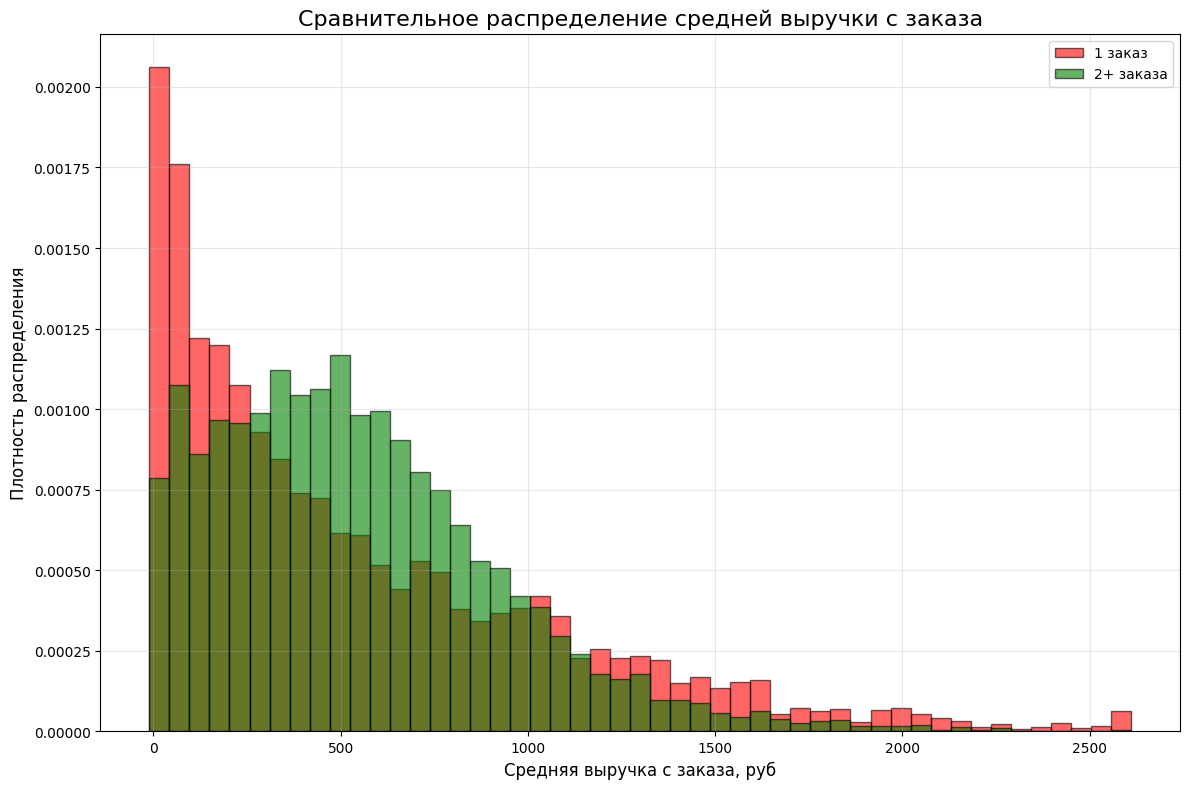

In [84]:
plt.figure(figsize=(12, 8))

data_range = np.linspace(
    min(single_order_users['avg_revenue_rub'].min(), repeat_users['avg_revenue_rub'].min()),
    max(single_order_users['avg_revenue_rub'].max(), repeat_users['avg_revenue_rub'].max()),
    50
)

plt.hist(single_order_users['avg_revenue_rub'], bins=data_range, alpha=0.6, color='red', 
         label='1 заказ', edgecolor='black', density=True)
plt.hist(repeat_users['avg_revenue_rub'], bins=data_range, alpha=0.6, color='green', 
         label='2+ заказа', edgecolor='black', density=True)

plt.title('Сравнительное распределение средней выручки с заказа', fontsize=16)
plt.xlabel('Средняя выручка с заказа, руб', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По гистограммер распределения средней выручки для клиентов с одним заказом и клиентов с множеством заказов можно заметить, что у клиентов с одним заказом разброс значений больше, преобладают более дешевые билеты, в то время как клиенты с множеством заказов имеют более равномерное распределение значений
</div>

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [85]:
two_four_order_users = user_profile_filtered[(user_profile_filtered['total_orders'] >= 2) & (user_profile_filtered['total_orders'] <= 4)]
five_order_users = user_profile_filtered[user_profile_filtered['total_orders'] >= 5]

In [86]:
print(f"Пользователей с 2-4 заказами: {len(two_four_order_users):,}")
print(f"Пользователей с 5+ заказами: {len(five_order_users):,}")

print(f"\nСредняя выручка с заказа:")
print(f"  - 2-4 заказа: {two_four_order_users['avg_revenue_rub'].mean():.2f} руб.")
print(f"  - 5+ заказов: {five_order_users['avg_revenue_rub'].mean():.2f} руб.")

print(f"\nМедианная выручка с заказа:")
print(f"  - 2-4 заказа: {two_four_order_users['avg_revenue_rub'].median():.2f} руб.")
print(f"  - 5+ заказов: {five_order_users['avg_revenue_rub'].median():.2f} руб.")

Пользователей с 2-4 заказами: 6,539
Пользователей с 5+ заказами: 5,246

Средняя выручка с заказа:
  - 2-4 заказа: 549.73 руб.
  - 5+ заказов: 542.18 руб.

Медианная выручка с заказа:
  - 2-4 заказа: 467.93 руб.
  - 5+ заказов: 514.39 руб.


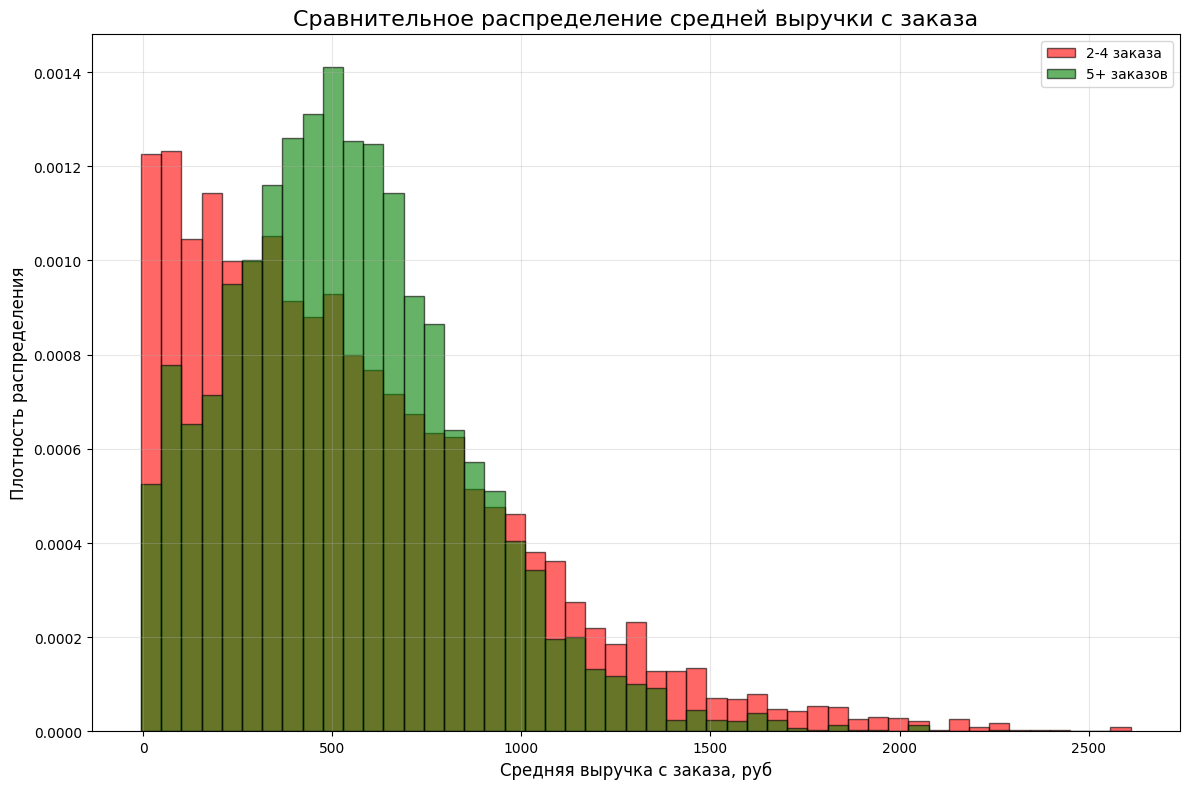

In [87]:
plt.figure(figsize=(12, 8))

data_range = np.linspace(
    min(two_four_order_users['avg_revenue_rub'].min(), five_order_users['avg_revenue_rub'].min()),
    max(two_four_order_users['avg_revenue_rub'].max(), five_order_users['avg_revenue_rub'].max()),
    50
)

plt.hist(two_four_order_users['avg_revenue_rub'], bins=data_range, alpha=0.6, color='red', 
         label='2-4 заказа', edgecolor='black', density=True)
plt.hist(five_order_users['avg_revenue_rub'], bins=data_range, alpha=0.6, color='green', 
         label='5+ заказов', edgecolor='black', density=True)

plt.title('Сравнительное распределение средней выручки с заказа', fontsize=16)
plt.xlabel('Средняя выручка с заказа, руб', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Тут похожая картина - разброс выручки от пользователей с 2-4 заказами больше, нежели у пользователей с 5+ заказами
</div>

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [88]:
user_profile = user_profile_filtered.copy()

In [89]:
segment_conditions = [
    (user_profile['avg_tickets'] >= 1) & (user_profile['avg_tickets'] < 2),
    (user_profile['avg_tickets'] >= 2) & (user_profile['avg_tickets'] < 3),
    (user_profile['avg_tickets'] >= 3) & (user_profile['avg_tickets'] < 5),
    (user_profile['avg_tickets'] >= 5)
]

segments = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']
user_profile.loc[:, 'ticket_segment'] = np.select(segment_conditions, segments, default='Другое')

In [90]:
segment_analysis = user_profile.groupby('ticket_segment').agg(
    total_users=('user_id', 'count'),
    users_with_2plus_orders=('is_two', 'sum'),
    avg_tickets=('avg_tickets', 'mean'),
    median_tickets=('avg_tickets', 'median')
).reset_index()

# Вычисляем доли
segment_analysis['percentage_of_total'] = (segment_analysis['total_users'] / len(user_profile) * 100).round(2)
segment_analysis['repeat_ratio'] = (segment_analysis['users_with_2plus_orders'] / segment_analysis['total_users'] * 100).round(2)

In [91]:
print("РАСПРЕДЕЛЕНИЕ ПО СЕГМЕНТАМ:")
for _, row in segment_analysis.iterrows():
    print(f"\n{row['ticket_segment']}:")
    print(f"  Пользователей: {row['total_users']:,} ({row['percentage_of_total']}%)")
    print(f"  Среднее количество билетов: {row['avg_tickets']:.2f}")
    print(f"  Медианное количество билетов: {row['median_tickets']:.2f}")
    print(f"  Пользователей с 2+ заказами: {row['users_with_2plus_orders']:,} ({row['repeat_ratio']}%)")

РАСПРЕДЕЛЕНИЕ ПО СЕГМЕНТАМ:

1-2 билета:
  Пользователей: 2,350 (11.66%)
  Среднее количество билетов: 1.26
  Медианное количество билетов: 1.00
  Пользователей с 2+ заказами: 1,172 (49.87%)

2-3 билета:
  Пользователей: 8,537 (42.38%)
  Среднее количество билетов: 2.30
  Медианное количество билетов: 2.25
  Пользователей с 2+ заказами: 6,028 (70.61%)

3-5 билетов:
  Пользователей: 8,611 (42.74%)
  Среднее количество билетов: 3.39
  Медианное количество билетов: 3.17
  Пользователей с 2+ заказами: 4,470 (51.91%)

5+ билетов:
  Пользователей: 648 (3.22%)
  Среднее количество билетов: 5.27
  Медианное количество билетов: 5.00
  Пользователей с 2+ заказами: 115 (17.75%)


<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
<li>Основное число клиентов ~85% покупают от 2 до 5 билетов</li>
<li>Аномально малое количество повторных покупок у сегмента со средним числом билетов 5+</li>
<li>Высокий процент клиентов с повторными покупками у сегмента с 2-3 билетами (70.61%)</li>
</ul>
</div>

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [92]:
df_sorted = df_filtered_tickets.sort_values(['user_id', 'order_ts'])

# Находим первый заказ для каждого пользователя
first_orders = df_sorted.groupby('user_id').first().reset_index()

# Добавляем день недели первого заказа
first_orders['first_order_weekday'] = pd.to_datetime(first_orders['order_dt']).dt.day_name()

In [93]:
first_orders.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub,first_order_weekday
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,край билетов,театр,каменевский регион,глиногорск,1521.94,Tuesday
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,75.0,237325,мой билет,выставки,каменевский регион,глиногорск,289.45,Tuesday
2,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,83.0,387271,лови билет!,другое,североярская область,озёрск,8.49,Saturday
3,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,NaN,201953,край билетов,театр,каменевский регион,глиногорск,917.83,Thursday
4,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,16.0,265857,лучшие билеты,театр,поленовский край,дальнозолотск,47.78,Sunday


In [94]:
# Добавляем информацию из первого заказа
user_profile = user_profile.merge(
    first_orders[['user_id', 'first_order_weekday']],
    on='user_id',
    how='left'
)

In [95]:
user_profile.head()

,user_id,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five,ticket_segment,first_order_weekday
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,0,0,3-5 билетов,Tuesday
1,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.000000,1,0,2-3 билета,Saturday
2,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,0,0,3-5 билетов,Thursday
3,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.000000,1,0,1-2 билета,Sunday
4,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,широковская область,лови билет!,концерты,13,1175.808462,3.307692,0.083333,1,1,3-5 билетов,Thursday


In [96]:
user_profile['first_order_weekday'].value_counts().sort_values(ascending=False)

first_order_weekday
Friday       3072
Saturday     3015
Thursday     2957
Tuesday      2940
Wednesday    2873
Monday       2727
Sunday       2562
Name: count, dtype: int64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Наиболее часто новые клиенты делают заказ в пятницу и субботу
</div>

In [97]:
# Вычисляем лайфтайм (время с момента первой покупки)
current_date = pd.to_datetime(df_filtered_tickets['order_dt']).max()
user_profile['lifetime_days'] = (current_date - user_profile['first_order_date']).dt.days

In [98]:
user_profile.head()

,user_id,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five,ticket_segment,first_order_weekday,lifetime_days
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,0,0,3-5 билетов,Tuesday,72
1,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.000000,1,0,2-3 билета,Saturday,110
2,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,0,0,3-5 билетов,Thursday,77
3,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.000000,1,0,1-2 билета,Sunday,32
4,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,широковская область,лови билет!,концерты,13,1175.808462,3.307692,0.083333,1,1,3-5 билетов,Thursday,133


In [99]:
user_profile['lifetime_days'].describe()

count    20146.000000
mean        77.491264
std         47.009301
min          0.000000
25%         35.000000
50%         76.000000
75%        121.000000
max        152.000000
Name: lifetime_days, dtype: float64

In [100]:
lifetime_segments = [
    (user_profile['lifetime_days'] <= 30, '0-30 дней'),
    ((user_profile['lifetime_days'] > 30) & (user_profile['lifetime_days'] <= 90), '31-90 дней'),
    (user_profile['lifetime_days'] > 90, '90+ дней')
]

user_profile['lifetime_segment'] = np.select(
    [condition for condition, _ in lifetime_segments],
    [segment for _, segment in lifetime_segments],
    default='Другое'
)

In [101]:
lifetime_analysis = user_profile.groupby('lifetime_segment').agg(
    total_users=('user_id', 'count'),
    repeat_users=('is_two', 'sum'),
    avg_lifetime=('lifetime_days', 'mean')
).reset_index()

lifetime_analysis['repeat_ratio'] = (lifetime_analysis['repeat_users'] / lifetime_analysis['total_users'] * 100).round(2)
lifetime_analysis['percentage_of_total'] = (lifetime_analysis['total_users'] / len(user_profile) * 100).round(2)

In [102]:
print(f"\nРаспределение по лайфтайму:")
for _, row in lifetime_analysis.iterrows():
    print(f"  {row['lifetime_segment']}: {row['total_users']} пользователей ({row['percentage_of_total']}%), "
          f"повторные: {row['repeat_ratio']}%")


Распределение по лайфтайму:
  0-30 дней: 4331 пользователей (21.5%), повторные: 37.54%
  31-90 дней: 7312 пользователей (36.3%), повторные: 55.07%
  90+ дней: 8503 пользователей (42.21%), повторные: 72.12%


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Логично, что у группы более старых пользователей наибольший процент повторных заказов
</div>

In [103]:
# Анализируем только пользователей с повторными покупками
repeat_buyers = user_profile[user_profile['total_orders'] >= 2]
repeat_buyers = repeat_buyers.copy()

In [104]:
interval_segments = [
    (repeat_buyers['avg_days_between_orders'] <= 3, '0-3 дня'),
    ((repeat_buyers['avg_days_between_orders'] > 3) & (repeat_buyers['avg_days_between_orders'] <= 7), '4-7 дней'),
    ((repeat_buyers['avg_days_between_orders'] > 7) & (repeat_buyers['avg_days_between_orders'] <= 14), '8-14 дней'),
    (repeat_buyers['avg_days_between_orders'] > 14, '15+ дней')
]
    
repeat_buyers['interval_segment'] = np.select(
    [condition for condition, _ in interval_segments],
    [segment for _, segment in interval_segments],
    default='Другое'
)

In [105]:
interval_analysis = repeat_buyers.groupby('interval_segment').agg(
    total_users=('user_id', 'count'),
    avg_interval=('avg_days_between_orders', 'mean'),
    avg_total_orders=('total_orders', 'mean')
).reset_index()

interval_analysis['percentage_of_repeaters'] = (interval_analysis['total_users'] / len(repeat_buyers) * 100).round(2)

In [106]:
print(f"\nРаспределение интервалов между покупками:")
for _, row in interval_analysis.iterrows():
    print(f"  {row['interval_segment']}: {row['total_users']:,} пользователей ({row['percentage_of_repeaters']}%), "
          f"ср. интервал: {row['avg_interval']:.1f} дней, ср. заказов: {row['avg_total_orders']:.1f}")


Распределение интервалов между покупками:
  0-3 дня: 3,657 пользователей (31.03%), ср. интервал: 0.4 дней, ср. заказов: 3.6
  15+ дней: 4,080 пользователей (34.62%), ср. интервал: 29.2 дней, ср. заказов: 4.3
  4-7 дней: 1,575 пользователей (13.36%), ср. интервал: 5.3 дней, ср. заказов: 13.7
  8-14 дней: 2,473 пользователей (20.98%), ср. интервал: 10.4 дней, ср. заказов: 8.9


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Наибольшее число заказов у пользователей, которые делают их с интервалом 4-7 дней
</div>

In [107]:
weekday_repeat_analysis = user_profile.groupby('first_order_weekday').agg(
    total_users=('user_id', 'count'),
    repeat_users=('is_two', 'sum')
)

In [108]:
weekday_repeat_analysis

,total_users,repeat_users
first_order_weekday,,
Friday,3072,1765
Monday,2727,1646
Saturday,3015,1778
Sunday,2562,1453
Thursday,2957,1695
Tuesday,2940,1732
Wednesday,2873,1716


In [109]:
weekday_repeat_analysis['repeat_ratio'] = (weekday_repeat_analysis['repeat_users'] / weekday_repeat_analysis['total_users'] * 100).round(2)

In [110]:
weekday_repeat_analysis.sort_values('repeat_ratio', ascending=False)

,total_users,repeat_users,repeat_ratio
first_order_weekday,,,
Monday,2727,1646,60.36
Wednesday,2873,1716,59.73
Saturday,3015,1778,58.97
Tuesday,2940,1732,58.91
Friday,3072,1765,57.45
Thursday,2957,1695,57.32
Sunday,2562,1453,56.71


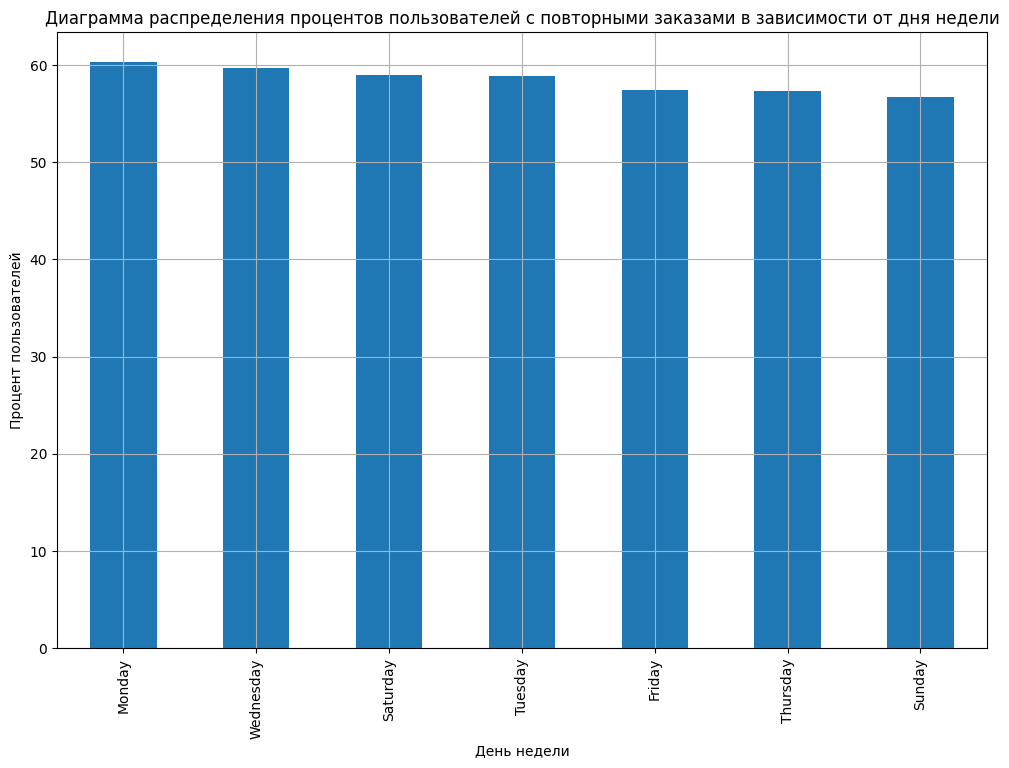

In [111]:
plt.figure(figsize=(12, 8))

weekday_repeat_analysis['repeat_ratio'].sort_values(ascending=False).plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Диаграмма распределения процентов пользователей с повторными заказами в зависимости от дня недели'
)

plt.grid()
plt.xlabel('День недели')
plt.ylabel('Процент пользователей')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Как мы видим наиболее выгодными днями недели являются понедельник и среда - если пользователь сделал свой первый заказ в эти дни, вероятность сделать повторный заказ выше
</div>

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [112]:
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]
group_5_plus = user_profile[user_profile['total_orders'] >= 5]

In [113]:
group_2_4['avg_days_between_orders'].describe()

count    6539.000000
mean       14.679627
std        17.823647
min         0.000000
25%         0.000000
50%         6.000000
75%        27.000000
max        64.000000
Name: avg_days_between_orders, dtype: float64

In [114]:
group_2_4['avg_days_between_orders'].value_counts()

avg_days_between_orders
0.000000     2446
1.000000      158
2.000000       94
3.000000       80
8.000000       74
             ... 
48.666667       1
14.750000       1
9.250000        1
49.333333       1
0.250000        1
Name: count, Length: 234, dtype: int64

In [115]:
group_2_4['avg_days_between_orders'].mean()

np.float64(14.679627364021004)

In [116]:
group_5_plus['avg_days_between_orders'].mean()

np.float64(11.119929397569988)

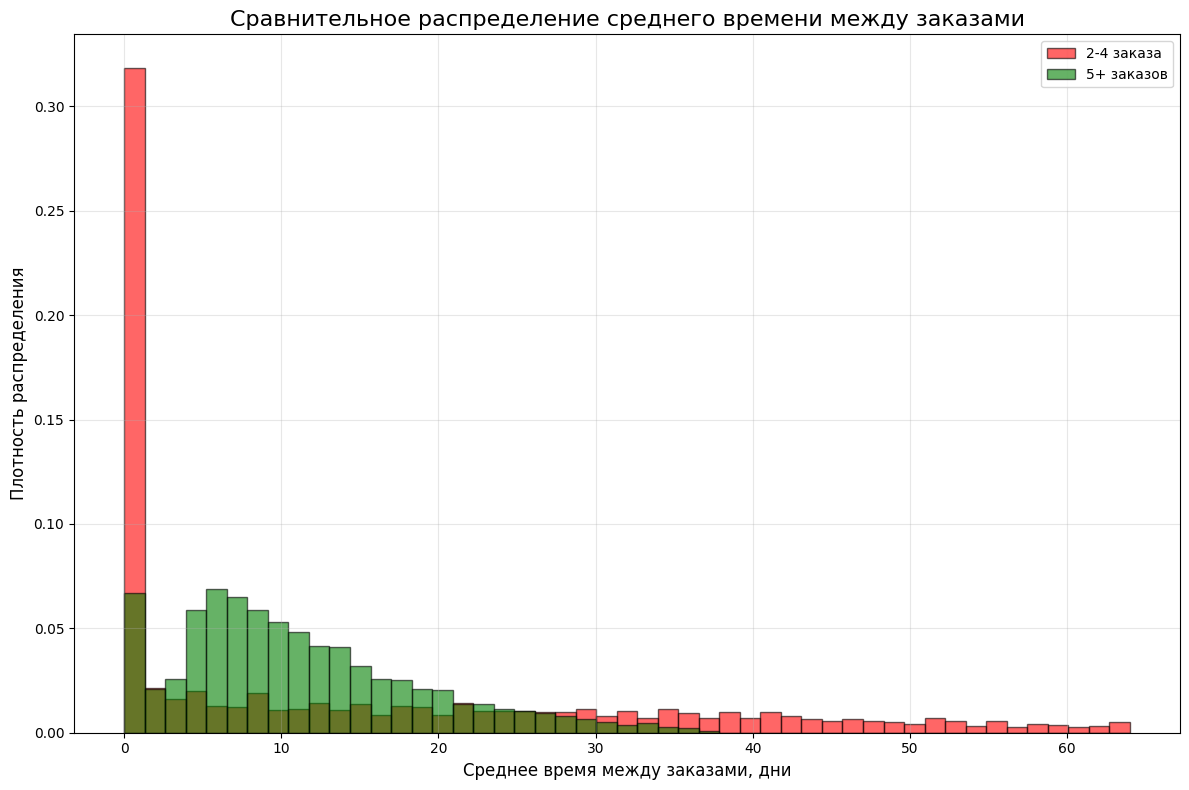

In [117]:
plt.figure(figsize=(12, 8))

data_range = np.linspace(
    min(group_2_4['avg_days_between_orders'].min(), group_5_plus['avg_days_between_orders'].min()),
    max(group_2_4['avg_days_between_orders'].max(), group_5_plus['avg_days_between_orders'].max()),
    50
)

plt.hist(group_2_4['avg_days_between_orders'], bins=data_range, alpha=0.6, color='red', 
         label='2-4 заказа', edgecolor='black', density=True)
plt.hist(group_5_plus['avg_days_between_orders'], bins=data_range, alpha=0.6, color='green', 
         label='5+ заказов', edgecolor='black', density=True)

plt.title('Сравнительное распределение среднего времени между заказами', fontsize=16)
plt.xlabel('Среднее время между заказами, дни', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По гистограмме распределения можно заметить, что большое количество пользователей (2446) с количеством заказов 2-4 совершают их в один день и далее не пользуются сервисом, поэтому если пользователь сделал до 4-х заказов в один день, то не маленькая вероятность того, что это были его первые и последние заказы
</div>

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [118]:
user_profile.head()

,user_id,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five,ticket_segment,first_order_weekday,lifetime_days,lifetime_segment
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,0,0,3-5 билетов,Tuesday,72,31-90 дней
1,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.000000,1,0,2-3 билета,Saturday,110,90+ дней
2,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,0,0,3-5 билетов,Thursday,77,31-90 дней
3,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.000000,1,0,1-2 билета,Sunday,32,31-90 дней
4,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,широковская область,лови билет!,концерты,13,1175.808462,3.307692,0.083333,1,1,3-5 билетов,Thursday,133,90+ дней


In [119]:
correlation = user_profile[['total_orders', 'avg_days_between_orders', 'lifetime_days', 'avg_tickets', 'first_device', 'first_region', 'first_partner', 'first_genre', 'avg_revenue_rub', 'first_order_weekday']].phik_matrix(interval_cols=['lifetime_days', 'avg_revenue_rub', 'avg_days_between_orders', 'avg_tickets', 'total_orders'])

In [120]:
correlation

,total_orders,avg_days_between_orders,lifetime_days,avg_tickets,first_device,first_region,first_partner,first_genre,avg_revenue_rub,first_order_weekday
total_orders,1.000000,0.631175,0.449461,0.181174,0.053827,0.029446,0.045437,0.031955,0.275599,0.019245
avg_days_between_orders,0.631175,1.000000,0.460698,0.129088,0.000000,0.116387,0.079854,0.070895,0.218989,0.000000
lifetime_days,0.449461,0.460698,1.000000,0.120318,0.030217,0.346166,0.208502,0.150035,0.210682,0.139677
avg_tickets,0.181174,0.129088,0.120318,1.000000,0.041887,0.075719,0.061052,0.094050,0.336929,0.000000
first_device,0.053827,0.000000,0.030217,0.041887,1.000000,0.109430,0.081808,0.063127,0.077907,0.073594
first_region,0.029446,0.116387,0.346166,0.075719,0.109430,1.000000,0.697398,0.509501,0.372520,0.138442
first_partner,0.045437,0.079854,0.208502,0.061052,0.081808,0.697398,1.000000,0.587007,0.388263,0.064483
first_genre,0.031955,0.070895,0.150035,0.094050,0.063127,0.509501,0.587007,1.000000,0.337565,0.082876
avg_revenue_rub,0.275599,0.218989,0.210682,0.336929,0.077907,0.372520,0.388263,0.337565,1.000000,0.000000
first_order_weekday,0.019245,0.000000,0.139677,0.000000,0.073594,0.138442,0.064483,0.082876,0.000000,1.000000


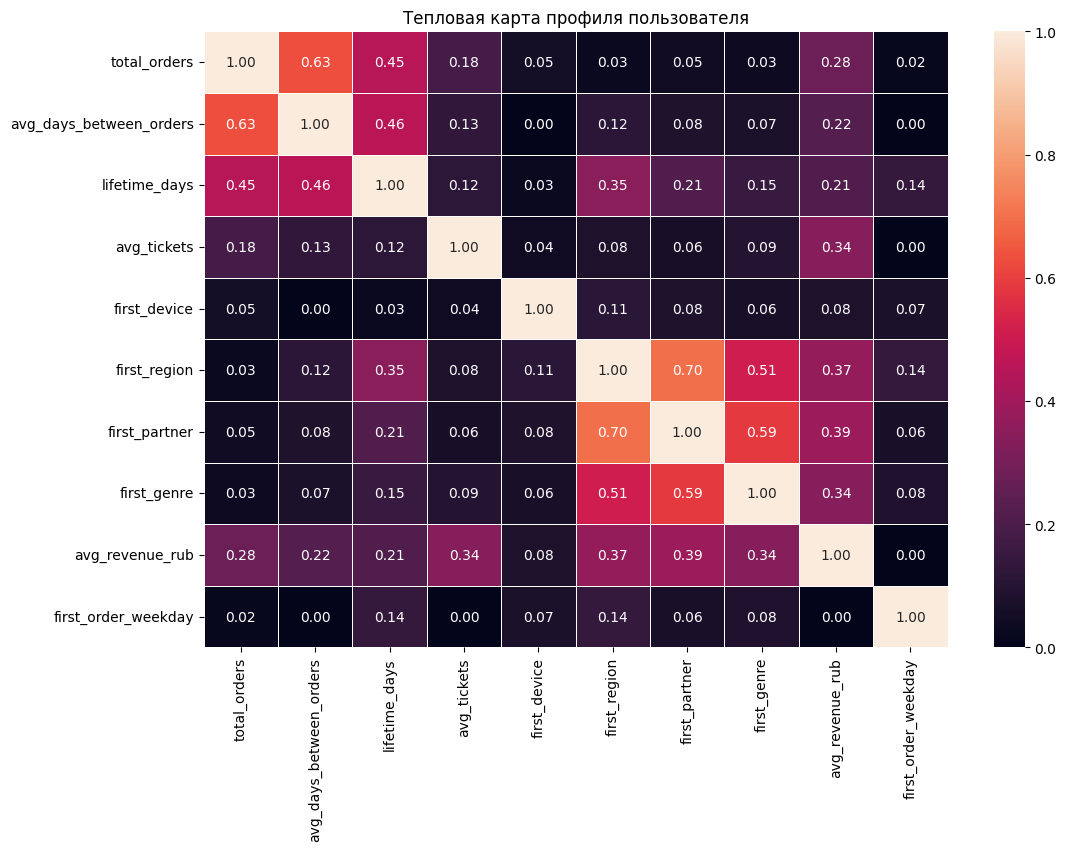

In [121]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=correlation, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта профиля пользователя')
plt.show()

In [122]:
group_1 = user_profile[user_profile['total_orders'] == 1]

In [123]:
correlation_1 = group_1[['avg_days_between_orders', 'lifetime_days', 'avg_tickets', 'first_device', 'first_region', 'first_partner', 'first_genre', 'avg_revenue_rub', 'first_order_weekday']].phik_matrix(interval_cols=['lifetime_days', 'avg_revenue_rub', 'avg_days_between_orders', 'avg_tickets'])
correlation_1

,avg_days_between_orders,lifetime_days,avg_tickets,first_device,first_region,first_partner,first_genre,avg_revenue_rub,first_order_weekday
avg_days_between_orders,1.000000,0.436691,0.489029,0.000000,0.000000,0.577653,0.680571,0.000000,0.000000
lifetime_days,0.436691,1.000000,0.058038,0.000000,0.345893,0.226244,0.144893,0.098126,0.133158
avg_tickets,0.489029,0.058038,1.000000,0.046608,0.000000,0.062345,0.109213,0.350413,0.021946
first_device,0.000000,0.000000,0.046608,1.000000,0.096000,0.072094,0.061626,0.093067,0.072534
first_region,0.000000,0.345893,0.000000,0.096000,1.000000,0.668384,0.505233,0.410870,0.134976
first_partner,0.577653,0.226244,0.062345,0.072094,0.668384,1.000000,0.580906,0.448582,0.059392
first_genre,0.680571,0.144893,0.109213,0.061626,0.505233,0.580906,1.000000,0.380648,0.094793
avg_revenue_rub,0.000000,0.098126,0.350413,0.093067,0.410870,0.448582,0.380648,1.000000,0.010280
first_order_weekday,0.000000,0.133158,0.021946,0.072534,0.134976,0.059392,0.094793,0.010280,1.000000


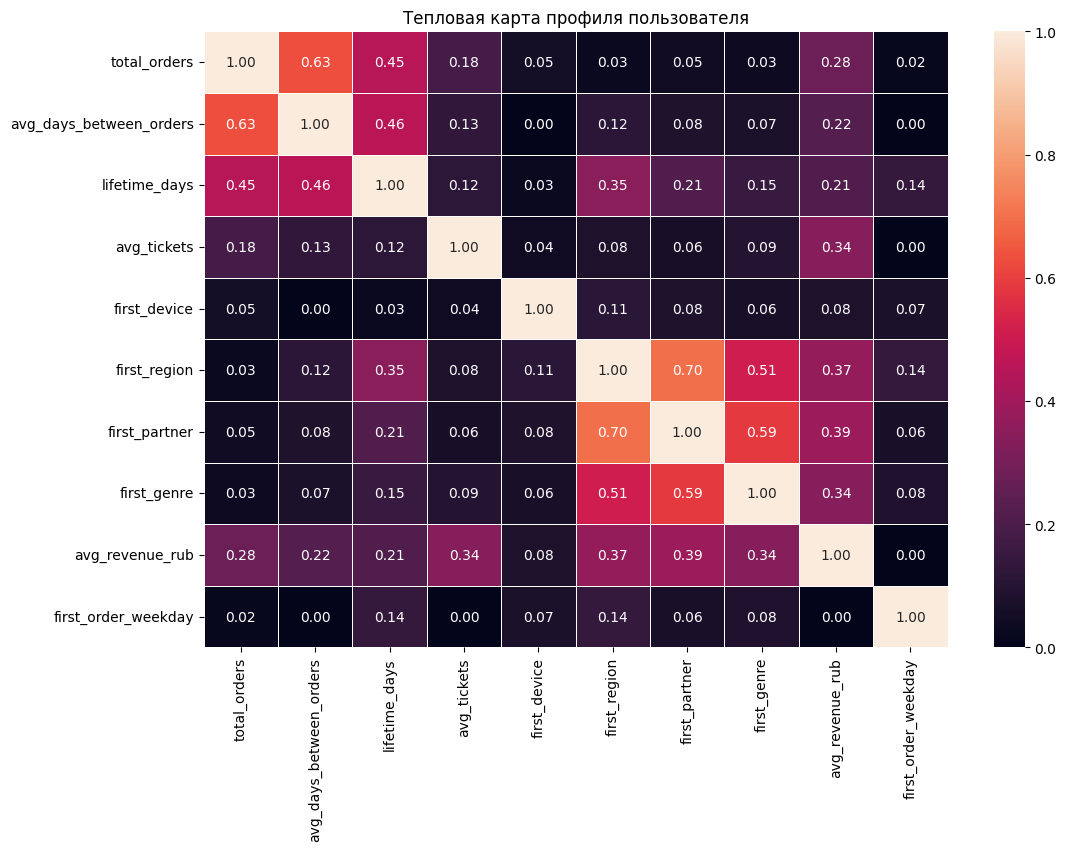

In [124]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=correlation, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта профиля пользователя')
plt.show()

In [125]:
correlation_2_4 = group_2_4[['total_orders', 'avg_days_between_orders', 'lifetime_days', 'avg_tickets', 'first_device', 'first_region', 'first_partner', 'first_genre', 'avg_revenue_rub', 'first_order_weekday']].phik_matrix(interval_cols=['lifetime_days', 'avg_revenue_rub', 'avg_days_between_orders', 'avg_tickets', 'total_orders'])
correlation_2_4

,total_orders,avg_days_between_orders,lifetime_days,avg_tickets,first_device,first_region,first_partner,first_genre,avg_revenue_rub,first_order_weekday
total_orders,1.000000,0.327293,0.257856,0.285491,0.008248,0.000000,0.074968,0.000000,0.131863,0.000000
avg_days_between_orders,0.327293,1.000000,0.529886,0.156477,0.000000,0.024727,0.000000,0.068803,0.187058,0.000000
lifetime_days,0.257856,0.529886,1.000000,0.093184,0.000000,0.355664,0.217509,0.143260,0.132621,0.154082
avg_tickets,0.285491,0.156477,0.093184,1.000000,0.079169,0.000000,0.028879,0.079720,0.439743,0.000000
first_device,0.008248,0.000000,0.000000,0.079169,1.000000,0.105347,0.065808,0.058080,0.051844,0.075969
first_region,0.000000,0.024727,0.355664,0.000000,0.105347,1.000000,0.683557,0.481333,0.328447,0.128305
first_partner,0.074968,0.000000,0.217509,0.028879,0.065808,0.683557,1.000000,0.577209,0.403752,0.075505
first_genre,0.000000,0.068803,0.143260,0.079720,0.058080,0.481333,0.577209,1.000000,0.335489,0.056124
avg_revenue_rub,0.131863,0.187058,0.132621,0.439743,0.051844,0.328447,0.403752,0.335489,1.000000,0.024197
first_order_weekday,0.000000,0.000000,0.154082,0.000000,0.075969,0.128305,0.075505,0.056124,0.024197,1.000000


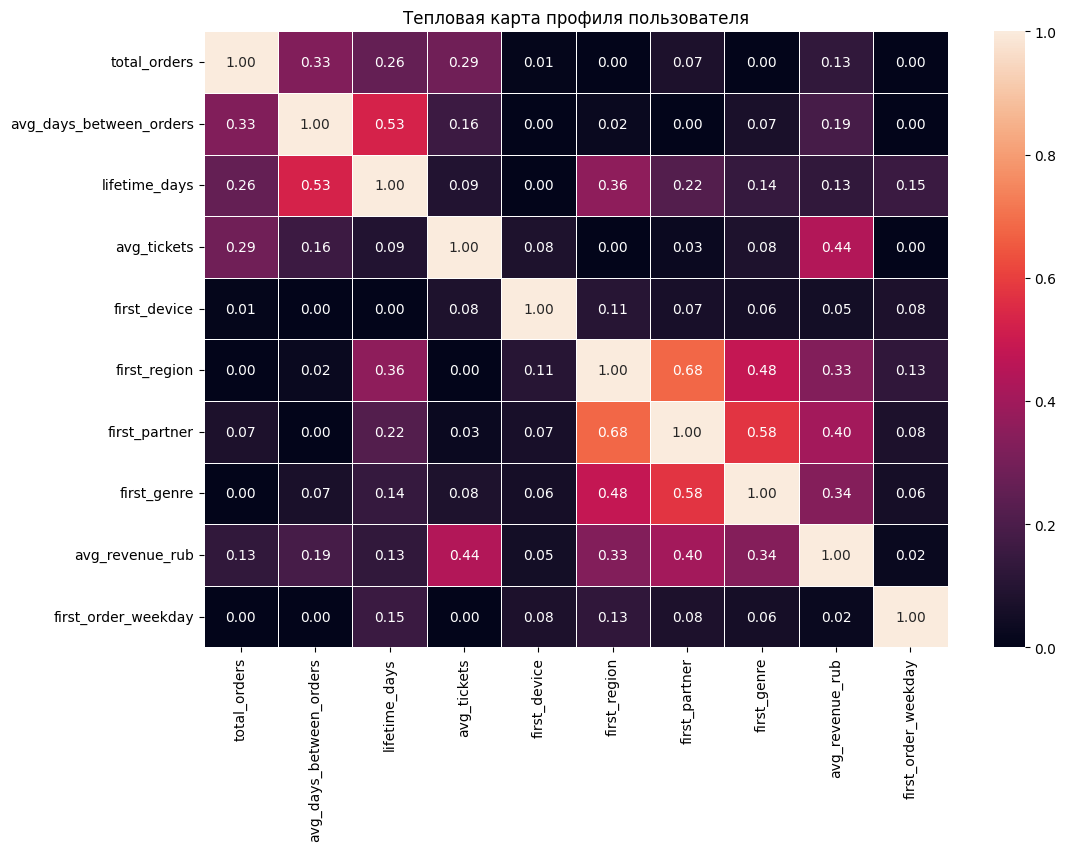

In [126]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=correlation_2_4, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта профиля пользователя')
plt.show()

In [127]:
correlation_5_plus = group_5_plus[['total_orders','avg_days_between_orders', 'lifetime_days', 'avg_tickets', 'first_device', 'first_region', 'first_partner', 'first_genre', 'avg_revenue_rub', 'first_order_weekday']].phik_matrix(interval_cols=['lifetime_days', 'avg_revenue_rub', 'avg_days_between_orders', 'avg_tickets', 'total_orders'])
correlation_5_plus

,total_orders,avg_days_between_orders,lifetime_days,avg_tickets,first_device,first_region,first_partner,first_genre,avg_revenue_rub,first_order_weekday
total_orders,1.000000,0.712198,0.335682,0.115582,0.037207,0.078256,0.059409,0.042649,0.164509,0.000000
avg_days_between_orders,0.712198,1.000000,0.616907,0.160073,0.000000,0.172964,0.000000,0.128043,0.275905,0.026425
lifetime_days,0.335682,0.616907,1.000000,0.164096,0.026743,0.373602,0.220945,0.187926,0.282119,0.148405
avg_tickets,0.115582,0.160073,0.164096,1.000000,0.035958,0.183780,0.060697,0.122580,0.341844,0.000000
first_device,0.037207,0.000000,0.026743,0.035958,1.000000,0.154153,0.093697,0.072443,0.074664,0.066642
first_region,0.078256,0.172964,0.373602,0.183780,0.154153,1.000000,0.686221,0.532144,0.363075,0.205752
first_partner,0.059409,0.000000,0.220945,0.060697,0.093697,0.686221,1.000000,0.574453,0.281493,0.087980
first_genre,0.042649,0.128043,0.187926,0.122580,0.072443,0.532144,0.574453,1.000000,0.255887,0.088525
avg_revenue_rub,0.164509,0.275905,0.282119,0.341844,0.074664,0.363075,0.281493,0.255887,1.000000,0.009971
first_order_weekday,0.000000,0.026425,0.148405,0.000000,0.066642,0.205752,0.087980,0.088525,0.009971,1.000000


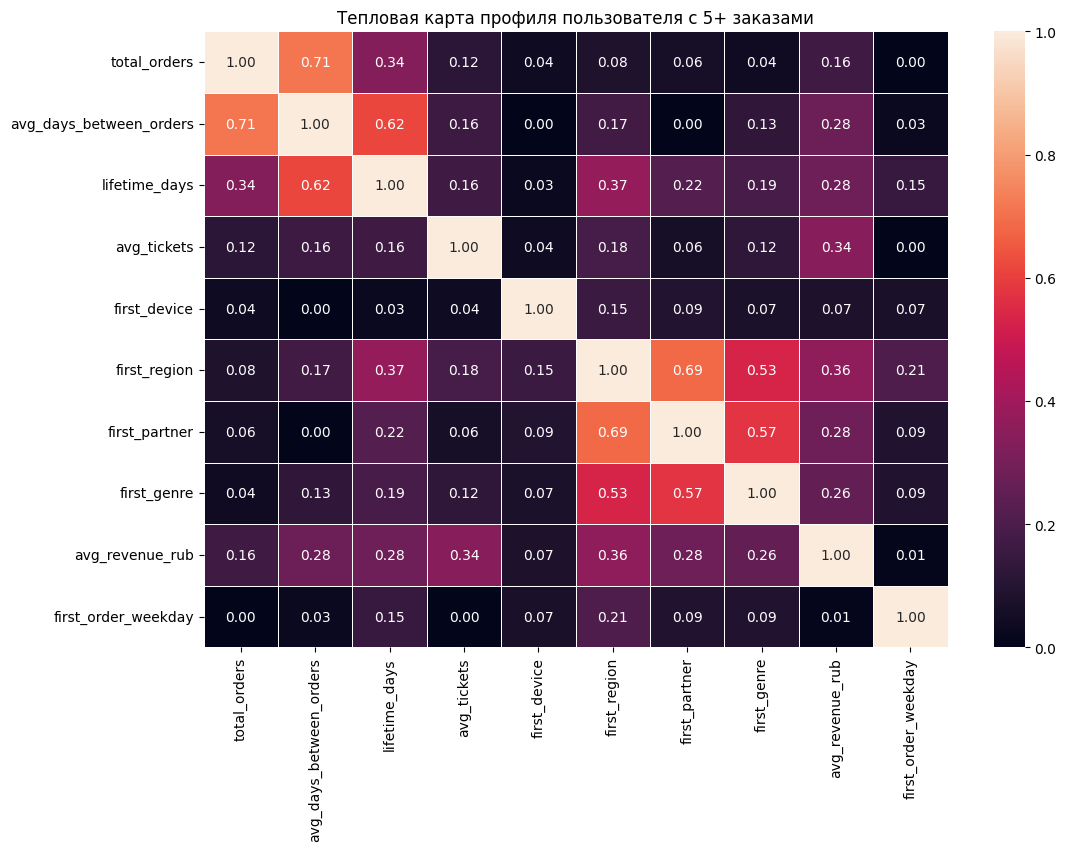

In [128]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=correlation_5_plus, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта профиля пользователя с 5+ заказами')
plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По тепловым картам, особенно для пользователей с 5+ заказами есть связь количества заказов со средним количеством дней между заказами (0.71), а также связь со временем между первой покупкой и настоящей датой. Так же могу отметить связь региона и оператора билетов - логично, что операторы могут изначально базироваться в определенных регионах и только позднее распространяться на другие
</div>

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

#### Общий обзор проделанной работы

<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
<li>В ходе исследования проанализировано и обработано 290611 записей о совершенных пользователями заказов в сервисе по продаже билетов на мероприятия, такие как концерты, кино, театр, спорт и др.</li>
    <li>Значения в столбце revenue были приведены к единой валюте - рублям и занесены в новый столбец revenue_rub, т.к. в существующем revenue значения были представлены как в рублях, так и в тенге</li>
    <li>Так же было отфильровано 2917 записей с аномально большой стоимостью и количеством билетов в заказе для более точного последующего анализа</li>
    <li>Нормализованы столбцы city_name, region_name, event_type_main, service_name</li>
</ul>
</div>

#### Ответы на исследовательские вопросы, или главные выводы

<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
    <li>Всего в предоставленной выборке 21849 пользователей после фильтрации, которые в свою очередь были так же отфильтрованы до 20146 из-за выбросов по числу заказов</li>
    <li>У ~41.5% пользователей только 1 заказ</li>
    <li>Основным поставщиком билетов является 'билеты без проблем' - ~23.86% что почти в 2 раза больше чем у оператора на втором месте</li>
    <li>В основном у клиентов в заказе 2 или 3 билета</li>
    <li>Концерты - наиболее популярный тип билетов для первого заказа - их ~44% по сравнению с 'другое' (~25%)</li>
    <li>В основном первый заказ делают с мобильного устройства - почти 83% пользователей</li>
    <li>А из регонов для первого мероприятия выделяются 'каменевский регион' - 32.43% и 'североярская область' - 17.29%</li>
    <li>Наиболее часто новые клиенты делают заказ в пятницу и субботу</li>
    <li>Наиболее выгодными днями недели являются понедельник и среда - если пользователь сделал свой первый заказ в эти дни, вероятность сделать повторный заказ выше</li>
    <li>Высокий процент клиентов с повторными покупками у сегмента с 2-3 билетами (70.61%)</li>
    <li>Вероятность повторной покупки выше, если средняя выручка приближена к средним значениям выручки по выборке</li>
    <li>Наибольшее число заказов у пользователей, которые делают их с интервалом 4-7 дней</li>
    <li>По результатам кореляционного анализа есть связь количества заказов со средним количеством дней между заказами (0.71), а также связь со временем между первой покупкой и настоящей датой (lifetime)</li>
</ul>
</div>

#### Рекомендации на основе анализа данных

<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
    <li>Сделать основной упор на мобильное приложение, т.к. 83% пользователей делают первый заказ именно через него</li>
    <li>Сконцентрировать маркетинговые бюджеты на "Каменевском регионе" (32.43%) и "Североярской области" (17.29%)</li>
    <li>Возможно стоит обратить внимание на клиентов, у которых первый заказ содержит только один билет - вероятность возврата такого клиента ниже</li>
    <li>Пик новых заказов в пятницу-субботу - усилить рекламу в эти дни</li>
    <li>Из-за большой процента пользователей с одним заказом (41.5%) подумать над программой акций для второго заказа</li>
    <li>Интервал 4-7 дней между заказами - оптимальное время для напоминаний (пуши, email)</li>
    <li>Выручка близкая к средним значениям дает больше повторных покупок, поэтому стоит избегать слишком дешевых и дорогих предложений</li>
</ul>
</div>